# Loading Libraries

In [50]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import pandas as pd

import torch.utils.data
from torch import optim
import os
import skfda
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import itertools 
from sklearn.decomposition import PCA
import matplotlib as mpl
from sklearn.neighbors import LocalOutlierFactor


mpl.rcParams['figure.dpi'] = 300


# Loading Files

In [3]:
def wf(x):
    return '/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Data/' + x

In [60]:
V_GRF_stance_N = pd.read_csv(wf('V_GRF_stance_N.csv'), header = None)
ML_GRF_stance_N = pd.read_csv(wf('ML_GRF_stance_N.csv'), header = None)
AP_GRF_stance_N = pd.read_csv(wf('AP_GRF_stance_N.csv'), header = None)
ID_info = pd.read_csv(wf('IDinfo.csv'), header = None)

In [99]:
V_GRF_stance_N_matrix = V_GRF_stance_N.to_numpy()
ML_GRF_stance_N_matrix = ML_GRF_stance_N.to_numpy()
AP_GRF_stance_N_matrix = AP_GRF_stance_N.to_numpy()
ID_info_matrix = ID_info.to_numpy()

In [100]:
#Defining a list of grid points
grid_points_100 = list(range(1,101))
grid_points_2990 = list(range(1,2991))

In [101]:
V_GRF_stance_N_fd = skfda.FDataGrid(data_matrix=V_GRF_stance_N_matrix,grid_points=grid_points_100)
V_GRF_stance_N_mean = skfda.exploratory.stats.mean(V_GRF_stance_N_fd)

ML_GRF_stance_N_fd = skfda.FDataGrid(data_matrix=ML_GRF_stance_N_matrix,grid_points=grid_points_100)
ML_GRF_stance_N_mean = skfda.exploratory.stats.mean(ML_GRF_stance_N_fd)

AP_GRF_stance_N_fd = skfda.FDataGrid(data_matrix=AP_GRF_stance_N_matrix,grid_points=grid_points_100)
AP_GRF_stance_N_mean = skfda.exploratory.stats.mean(AP_GRF_stance_N_fd)

In [8]:
V_GRF_stance_N_mean_array = np.zeros((15696,100))
for j in range(0,15696):
    for i in range(0,100):
        val = V_GRF_stance_N_mean.data_matrix[0,i,0]
        V_GRF_stance_N_mean_array[j,i] = val
    
ML_GRF_stance_N_mean_array = np.zeros((15696,100))
for j in range(0,15696):
    for i in range(0,100):
        val = ML_GRF_stance_N_mean.data_matrix[0,i,0]
        ML_GRF_stance_N_mean_array[j,i] = val
    
AP_GRF_stance_N_mean_array = np.zeros((15696,100))
for j in range(0,15696):
    for i in range(0,100):
        val = AP_GRF_stance_N_mean.data_matrix[0,i,0]
        AP_GRF_stance_N_mean_array[j,i] = val

# Defining VAE

In [9]:
class InfoVAE(nn.Module):
    def __init__(self,nfeat=100, ncode=5, alpha=0, lambd=10000, nhidden=128, nhidden2=35, dropout=0.2):
        super(InfoVAE, self).__init__()
        
        self.ncode = int(ncode)
        self.alpha = float(alpha)
        self.lambd = float(lambd)
        
        self.encd = nn.Linear(nfeat, nhidden)
        self.d1 = nn.Dropout(p=dropout)
        self.enc2 = nn.Linear(nhidden, nhidden2)
        self.d2 = nn.Dropout(p=dropout)
        self.mu = nn.Linear(nhidden2, ncode)
        self.lv = nn.Linear(nhidden2, ncode)
        
        self.decd = nn.Linear(ncode, nhidden2)
        self.d3 = nn.Dropout(p=dropout)
        self.dec2 = nn.Linear(nhidden2, nhidden)
        self.d4 = nn.Dropout(p=dropout)
        self.outp = nn.Linear(nhidden, nfeat)
        
    def encode(self, x):
        x = self.d1(F.leaky_relu(self.encd(x)))
        x = self.d2(F.leaky_relu(self.enc2(x)))
        mu = self.mu(x)
        logvar = self.lv(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, x):
        x = self.d3(F.leaky_relu(self.decd(x)))
        x = self.d4(F.leaky_relu(self.dec2(x)))
        x = self.outp(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    # https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
    def compute_kernel(self, x, y):
        x_size = x.size(0)
        y_size = y.size(0)
        dim = x.size(1)
        x = x.unsqueeze(1) # (x_size, 1, dim)
        y = y.unsqueeze(0) # (1, y_size, dim)
        tiled_x = x.expand(x_size, y_size, dim)
        tiled_y = y.expand(x_size, y_size, dim)
        # The example code divides by (dim) here, making <kernel_input> ~ 1/dim
        # excluding (dim) makes <kernel_input> ~ 1
        kernel_input = (tiled_x - tiled_y).pow(2).mean(2)#/float(dim)
        return torch.exp(-kernel_input) # (x_size, y_size)
    
    # https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
    def compute_mmd(self, x, y):
        xx_kernel = self.compute_kernel(x,x)
        yy_kernel = self.compute_kernel(y,y)
        xy_kernel = self.compute_kernel(x,y)
        return torch.mean(xx_kernel) + torch.mean(yy_kernel) - 2*torch.mean(xy_kernel)
    
    def loss(self, x, epoch):
        recon_x, mu, logvar = self.forward(x)
        MSE = torch.sum(0.5 *  (x - recon_x).pow(2))
        
        # KL divergence (Kingma and Welling, https://arxiv.org/abs/1312.6114, Appendix B)
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        #return MSE + self.beta*KLD, MSE
                
        # https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
        true_samples = Variable(torch.randn(200, self.ncode), requires_grad=False)
        z = self.reparameterize(mu, logvar) #duplicate call
        # compute MMD ~ 1, so upweight to match KLD which is ~ n_batch x n_code
        MMD = self.compute_mmd(true_samples,z) * x.size(0) * self.ncode
        return MSE + (1-self.alpha)*KLD + (self.lambd+self.alpha-1)*MMD, MSE, KLD, MMD

# Preparing Test and Train datasets for model fitting

# APGRF

In [10]:
trainfrac = 0.75
ntrain = int(AP_GRF_stance_N_matrix.shape[0] * trainfrac)
nvalid = AP_GRF_stance_N_matrix.shape[0] - ntrain
nfeat = AP_GRF_stance_N_matrix.shape[1]
np.random.seed(20190425) # make validation set deterministic
permutation = np.random.permutation(AP_GRF_stance_N_matrix.shape[0])
np.random.seed()
trainidx = permutation[0:ntrain]
valididx = permutation[-1-nvalid:-1]

train_apgrf = AP_GRF_stance_N_matrix[trainidx,:]
valid_apgrf = AP_GRF_stance_N_matrix[valididx,:]

In [11]:
batch_size=64

dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(train_apgrf, dtype=torch.float32)),
    batch_size=batch_size,
    shuffle=True)

valdloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(valid_apgrf, dtype=torch.float32)),
    batch_size=nvalid)

## Defining Training function

In [12]:
def train(): #model, optimizer, epoch, min_valid_loss, badepochs
    model.train()
    train_loss = 0
    train_logL = 0
    for batch_idx, data in enumerate(dataloader):
        spectrum = data[0]
        optimizer.zero_grad()
        loss, logL, KLD, MMD = model.loss(spectrum, epoch)
        loss.backward()
        train_loss += loss.item()
        train_logL += logL.item()
        optimizer.step()
    train_loss /= len(dataloader.dataset)
    
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        valid_logL = 0
        valid_KLD = 0
        valid_MMD = 0

        for valddata in valdloader:
            spectrum = valddata[0]
            loss, logL, KLD, MMD = model.loss(spectrum, epoch)
            valid_loss += loss.item()
            valid_logL += logL.item()
            valid_KLD += KLD.item()
            valid_MMD += MMD.item()
        
        valid_loss /= len(valdloader.dataset)
        valid_logL /= -len(valdloader.dataset)
        valid_KLD  /= len(valdloader.dataset)
        valid_MMD  /= len(valdloader.dataset)
    return valid_loss, valid_logL, valid_KLD, valid_MMD

In [13]:
class EarlyStopper:
    def __init__(self, precision=1e-3, patience=10):
        self.precision = precision
        self.patience = patience
        self.badepochs = 0
        self.min_valid_loss = float('inf')
        
    def step(self, valid_loss):
        if valid_loss < self.min_valid_loss*(1-self.precision):
            self.badepochs = 0
            self.min_valid_loss = valid_loss
        else:
            self.badepochs += 1
        return not (self.badepochs == self.patience)

# Setting training parameters

In [14]:
epochs = 200
log_interval = 10
mdl_ncode_l = range(2,11,2)
n_config_l = range(100)
test_list = [n_config_l,mdl_ncode_l]

mdl_MSE = np.zeros((100, 5))
mdl_KLD = np.zeros((100, 5))
mdl_MMD = np.zeros((100, 5))

In [15]:
tag = '/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Models/GRFy'
# Parent Directory path
parent_dir = '/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Models/'
# Path

# Training 100 models for 5 different encoder shapes

In [12]:
for config, mdl_ncode in itertools.product(n_config_l,mdl_ncode_l):
    alpha = 0
    lambd = np.exp(np.random.uniform(0, np.log(1e5)))
    dropout = 0#0.9*np.random.uniform()
    dfac = 1./(1.-dropout)
    nhidden = int(np.ceil(np.exp(np.random.uniform(np.log(dfac*mdl_ncode+1), np.log(dfac*2*nfeat)))))
    nhidden2 = int(np.ceil(np.exp(np.random.uniform(np.log(dfac*mdl_ncode+1), np.log(nhidden)))))
    print('config %i, alpha = %0.1f, lambda = %0.1f, dropout = %0.2f; 2 hidden layers with %i, %i nodes' % (config, alpha, lambd, dropout, nhidden, nhidden2))
    model = InfoVAE(alpha=alpha, lambd=lambd, nfeat=nfeat, nhidden=nhidden, nhidden2=nhidden2, ncode=mdl_ncode, dropout=dropout)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=5)
    stopper = EarlyStopper(patience=10)

    for epoch in range(1, epochs + 1):
        valid_loss, valid_logL, valid_KLD, valid_MMD = train()
        if epoch % log_interval == 0:
            print('====> Epoch: {} VALIDATION Loss: {:.2e} logL: {:.2e} KL: {:.2e} MMD: {:.2e}'.format(
                  epoch, valid_loss, valid_logL, valid_KLD, valid_MMD))

        scheduler.step(valid_loss)
        if (not stopper.step(valid_loss)) or (epoch == epochs):
            
            if mdl_ncode == 2:
                p_i = 0
            elif mdl_ncode == 4:
                p_i = 1
            elif mdl_ncode == 6:
                p_i = 2
            elif mdl_ncode == 8:
                p_i = 3
            elif mdl_ncode == 10:
                p_i = 4
                
            print('Stopping')
            print('====> Epoch: {} VALIDATION Loss: {:.2e} logL: {:.2e} KL: {:.2e} MMD: {:.2e}'.format(
                  epoch, valid_loss, valid_logL, valid_KLD, valid_MMD))
            model.MSE = -valid_logL
            model.KLD = valid_KLD
            model.MMD = valid_MMD
            mdl_MSE[config,p_i] = model.MSE
            mdl_KLD[config,p_i] = model.KLD
            mdl_MMD[config,p_i] = model.MMD
            torch.save(model, tag +'/%i' % mdl_ncode +'/%04i.pth' % config  )
            break


config 0, alpha = 0.0, lambda = 28183.0, dropout = 0.00; 2 hidden layers with 11, 7 nodes
====> Epoch: 10 VALIDATION Loss: 3.41e+04 logL: -1.38e+04 KL: 7.08e+02 MMD: 6.96e-01
====> Epoch: 20 VALIDATION Loss: 3.37e+04 logL: -1.36e+04 KL: 4.83e+02 MMD: 6.96e-01
Epoch 00024: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 30 VALIDATION Loss: 3.39e+04 logL: -1.29e+04 KL: 4.22e+02 MMD: 7.29e-01
Epoch 00032: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 36 VALIDATION Loss: 3.14e+04 logL: -1.27e+04 KL: 4.24e+02 MMD: 6.49e-01
config 0, alpha = 0.0, lambda = 570.6, dropout = 0.00; 2 hidden layers with 11, 6 nodes
====> Epoch: 10 VALIDATION Loss: 2.07e+04 logL: -1.91e+04 KL: 9.83e+02 MMD: 1.06e+00
====> Epoch: 20 VALIDATION Loss: 1.75e+04 logL: -1.61e+04 KL: 8.99e+02 MMD: 1.02e+00
====> Epoch: 30 VALIDATION Loss: 1.56e+04 logL: -1.45e+04 KL: 5.37e+02 MMD: 9.68e-01
====> Epoch: 40 VALIDATION Loss: 1.29e+04 logL: -1.20e+04 KL: 3.19e+02 MMD: 1.07e+00
====> Epo

====> Epoch: 100 VALIDATION Loss: 1.24e+04 logL: -1.11e+04 KL: 1.04e+03 MMD: 1.78e+00
====> Epoch: 110 VALIDATION Loss: 1.09e+04 logL: -1.00e+04 KL: 6.42e+02 MMD: 1.68e+00
====> Epoch: 120 VALIDATION Loss: 1.01e+04 logL: -9.54e+03 KL: 4.10e+02 MMD: 1.75e+00
====> Epoch: 130 VALIDATION Loss: 9.50e+03 logL: -9.00e+03 KL: 3.13e+02 MMD: 1.64e+00
====> Epoch: 140 VALIDATION Loss: 9.03e+03 logL: -8.61e+03 KL: 2.52e+02 MMD: 1.55e+00
====> Epoch: 150 VALIDATION Loss: 7.93e+03 logL: -7.53e+03 KL: 2.17e+02 MMD: 1.63e+00
====> Epoch: 160 VALIDATION Loss: 6.42e+03 logL: -6.06e+03 KL: 1.80e+02 MMD: 1.60e+00
====> Epoch: 170 VALIDATION Loss: 4.10e+03 logL: -3.73e+03 KL: 1.75e+02 MMD: 1.65e+00
====> Epoch: 180 VALIDATION Loss: 3.49e+03 logL: -3.14e+03 KL: 1.44e+02 MMD: 1.77e+00
====> Epoch: 190 VALIDATION Loss: 3.27e+03 logL: -2.94e+03 KL: 1.25e+02 MMD: 1.75e+00
====> Epoch: 200 VALIDATION Loss: 3.13e+03 logL: -2.82e+03 KL: 1.12e+02 MMD: 1.72e+00
Stopping
====> Epoch: 200 VALIDATION Loss: 3.13e+03 lo

====> Epoch: 10 VALIDATION Loss: 1.72e+04 logL: -1.52e+04 KL: 8.75e+02 MMD: 1.40e+00
====> Epoch: 20 VALIDATION Loss: 1.56e+04 logL: -1.41e+04 KL: 4.14e+02 MMD: 1.41e+00
====> Epoch: 30 VALIDATION Loss: 1.50e+04 logL: -1.37e+04 KL: 2.37e+02 MMD: 1.37e+00
====> Epoch: 40 VALIDATION Loss: 9.41e+03 logL: -8.10e+03 KL: 2.85e+02 MMD: 1.27e+00
====> Epoch: 50 VALIDATION Loss: 8.65e+03 logL: -7.38e+03 KL: 1.97e+02 MMD: 1.32e+00
====> Epoch: 60 VALIDATION Loss: 8.49e+03 logL: -7.21e+03 KL: 1.47e+02 MMD: 1.39e+00
====> Epoch: 70 VALIDATION Loss: 8.44e+03 logL: -7.20e+03 KL: 1.17e+02 MMD: 1.39e+00
Epoch 00079: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 80 VALIDATION Loss: 8.37e+03 logL: -7.09e+03 KL: 1.00e+02 MMD: 1.46e+00
Epoch 00088: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 90 VALIDATION Loss: 8.26e+03 logL: -7.08e+03 KL: 9.86e+01 MMD: 1.33e+00
Stopping
====> Epoch: 92 VALIDATION Loss: 8.34e+03 logL: -7.08e+03 KL: 9.86e+01 MMD: 1.43e+00
config 3, alpha =

====> Epoch: 20 VALIDATION Loss: 7.69e+03 logL: -5.50e+03 KL: 3.17e+02 MMD: 1.93e+00
====> Epoch: 30 VALIDATION Loss: 5.66e+03 logL: -3.68e+03 KL: 2.10e+02 MMD: 1.83e+00
====> Epoch: 40 VALIDATION Loss: 4.85e+03 logL: -2.84e+03 KL: 1.76e+02 MMD: 1.90e+00
====> Epoch: 50 VALIDATION Loss: 4.80e+03 logL: -2.80e+03 KL: 1.42e+02 MMD: 1.92e+00
Epoch 00055: reducing learning rate of group 0 to 1.0000e-04.
Stopping
====> Epoch: 59 VALIDATION Loss: 4.71e+03 logL: -2.74e+03 KL: 1.30e+02 MMD: 1.91e+00
config 5, alpha = 0.0, lambda = 683.4, dropout = 0.00; 2 hidden layers with 148, 134 nodes
====> Epoch: 10 VALIDATION Loss: 1.03e+04 logL: -9.59e+03 KL: 2.06e+02 MMD: 6.76e-01
====> Epoch: 20 VALIDATION Loss: 1.01e+04 logL: -9.49e+03 KL: 1.25e+02 MMD: 7.05e-01
====> Epoch: 30 VALIDATION Loss: 1.00e+04 logL: -9.47e+03 KL: 1.11e+02 MMD: 6.45e-01
====> Epoch: 40 VALIDATION Loss: 9.84e+03 logL: -9.25e+03 KL: 1.23e+02 MMD: 6.91e-01
====> Epoch: 50 VALIDATION Loss: 9.51e+03 logL: -8.91e+03 KL: 1.28e+02 MM

====> Epoch: 40 VALIDATION Loss: 3.23e+04 logL: -1.48e+04 KL: 2.73e+02 MMD: 1.31e+00
Stopping
====> Epoch: 41 VALIDATION Loss: 3.32e+04 logL: -1.48e+04 KL: 2.73e+02 MMD: 1.38e+00
config 6, alpha = 0.0, lambda = 34.6, dropout = 0.00; 2 hidden layers with 74, 33 nodes
====> Epoch: 10 VALIDATION Loss: 7.96e+03 logL: -7.47e+03 KL: 4.32e+02 MMD: 1.52e+00
====> Epoch: 20 VALIDATION Loss: 5.58e+03 logL: -5.27e+03 KL: 2.52e+02 MMD: 1.68e+00
====> Epoch: 30 VALIDATION Loss: 3.05e+03 logL: -2.80e+03 KL: 1.99e+02 MMD: 1.57e+00
====> Epoch: 40 VALIDATION Loss: 3.13e+03 logL: -2.92e+03 KL: 1.55e+02 MMD: 1.67e+00
====> Epoch: 50 VALIDATION Loss: 2.71e+03 logL: -2.51e+03 KL: 1.50e+02 MMD: 1.76e+00
====> Epoch: 60 VALIDATION Loss: 1.82e+03 logL: -1.64e+03 KL: 1.25e+02 MMD: 1.65e+00
====> Epoch: 70 VALIDATION Loss: 1.77e+03 logL: -1.61e+03 KL: 1.08e+02 MMD: 1.61e+00
Epoch 00074: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 80 VALIDATION Loss: 1.71e+03 logL: -1.55e+03 KL: 1.01e+02 MMD: 

====> Epoch: 10 VALIDATION Loss: 9.75e+03 logL: -9.57e+03 KL: 1.73e+02 MMD: 6.65e-01
====> Epoch: 20 VALIDATION Loss: 9.59e+03 logL: -9.49e+03 KL: 9.41e+01 MMD: 7.47e-01
====> Epoch: 30 VALIDATION Loss: 9.51e+03 logL: -9.44e+03 KL: 6.89e+01 MMD: 7.47e-01
====> Epoch: 40 VALIDATION Loss: 9.45e+03 logL: -9.38e+03 KL: 6.05e+01 MMD: 7.70e-01
====> Epoch: 50 VALIDATION Loss: 9.20e+03 logL: -9.14e+03 KL: 5.52e+01 MMD: 7.48e-01
====> Epoch: 60 VALIDATION Loss: 9.62e+03 logL: -9.58e+03 KL: 4.23e+01 MMD: 8.46e-01
====> Epoch: 70 VALIDATION Loss: 9.05e+03 logL: -9.01e+03 KL: 3.81e+01 MMD: 7.86e-01
====> Epoch: 80 VALIDATION Loss: 9.38e+03 logL: -9.35e+03 KL: 3.43e+01 MMD: 8.42e-01
Epoch 00081: reducing learning rate of group 0 to 1.0000e-04.
Stopping
====> Epoch: 85 VALIDATION Loss: 8.97e+03 logL: -8.93e+03 KL: 3.59e+01 MMD: 8.48e-01
config 8, alpha = 0.0, lambda = 69924.3, dropout = 0.00; 2 hidden layers with 37, 7 nodes
====> Epoch: 10 VALIDATION Loss: 1.94e+04 logL: -1.54e+04 KL: 2.80e+00 MMD

====> Epoch: 190 VALIDATION Loss: 5.75e+03 logL: -5.29e+03 KL: 1.00e+02 MMD: 1.03e+00
====> Epoch: 200 VALIDATION Loss: 5.60e+03 logL: -5.14e+03 KL: 8.74e+01 MMD: 1.07e+00
Stopping
====> Epoch: 200 VALIDATION Loss: 5.60e+03 logL: -5.14e+03 KL: 8.74e+01 MMD: 1.07e+00
config 9, alpha = 0.0, lambda = 93823.1, dropout = 0.00; 2 hidden layers with 83, 11 nodes
====> Epoch: 10 VALIDATION Loss: 1.30e+05 logL: -1.17e+04 KL: 8.32e+02 MMD: 1.25e+00
====> Epoch: 20 VALIDATION Loss: 1.35e+05 logL: -8.07e+03 KL: 5.11e+02 MMD: 1.35e+00
Epoch 00021: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 30 VALIDATION Loss: 1.43e+05 logL: -7.31e+03 KL: 5.21e+02 MMD: 1.44e+00
Epoch 00033: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 40 VALIDATION Loss: 1.26e+05 logL: -7.28e+03 KL: 5.02e+02 MMD: 1.26e+00
Epoch 00043: reducing learning rate of group 0 to 1.0000e-06.
Stopping
====> Epoch: 47 VALIDATION Loss: 1.23e+05 logL: -7.27e+03 KL: 5.00e+02 MMD: 1.23e+00
config 9, alpha = 0.0,

====> Epoch: 10 VALIDATION Loss: 1.42e+04 logL: -1.37e+04 KL: 4.75e+02 MMD: 1.52e+00
====> Epoch: 20 VALIDATION Loss: 1.39e+04 logL: -1.36e+04 KL: 2.58e+02 MMD: 1.69e+00
====> Epoch: 30 VALIDATION Loss: 1.37e+04 logL: -1.35e+04 KL: 1.51e+02 MMD: 1.90e+00
====> Epoch: 40 VALIDATION Loss: 1.37e+04 logL: -1.35e+04 KL: 1.16e+02 MMD: 1.91e+00
====> Epoch: 50 VALIDATION Loss: 1.36e+04 logL: -1.35e+04 KL: 9.34e+01 MMD: 2.07e+00
====> Epoch: 60 VALIDATION Loss: 1.36e+04 logL: -1.34e+04 KL: 7.82e+01 MMD: 2.18e+00
====> Epoch: 70 VALIDATION Loss: 1.35e+04 logL: -1.34e+04 KL: 6.59e+01 MMD: 2.21e+00
====> Epoch: 80 VALIDATION Loss: 1.35e+04 logL: -1.34e+04 KL: 5.61e+01 MMD: 2.34e+00
====> Epoch: 90 VALIDATION Loss: 1.34e+04 logL: -1.33e+04 KL: 5.27e+01 MMD: 2.15e+00
====> Epoch: 100 VALIDATION Loss: 9.64e+03 logL: -9.52e+03 KL: 9.67e+01 MMD: 1.38e+00
====> Epoch: 110 VALIDATION Loss: 9.58e+03 logL: -9.48e+03 KL: 7.21e+01 MMD: 1.53e+00
====> Epoch: 120 VALIDATION Loss: 9.53e+03 logL: -9.44e+03 KL: 

====> Epoch: 80 VALIDATION Loss: 1.61e+03 logL: -1.51e+03 KL: 9.08e+01 MMD: 1.60e+00
Epoch 00082: reducing learning rate of group 0 to 1.0000e-06.
Stopping
====> Epoch: 86 VALIDATION Loss: 1.61e+03 logL: -1.51e+03 KL: 9.07e+01 MMD: 1.62e+00
config 12, alpha = 0.0, lambda = 26.0, dropout = 0.00; 2 hidden layers with 151, 13 nodes
====> Epoch: 10 VALIDATION Loss: 1.46e+04 logL: -1.37e+04 KL: 8.83e+02 MMD: 2.16e+00
====> Epoch: 20 VALIDATION Loss: 1.13e+04 logL: -1.07e+04 KL: 5.05e+02 MMD: 1.99e+00
====> Epoch: 30 VALIDATION Loss: 8.40e+03 logL: -8.05e+03 KL: 2.98e+02 MMD: 1.93e+00
====> Epoch: 40 VALIDATION Loss: 5.48e+03 logL: -5.21e+03 KL: 2.19e+02 MMD: 1.87e+00
====> Epoch: 50 VALIDATION Loss: 3.88e+03 logL: -3.66e+03 KL: 1.70e+02 MMD: 1.86e+00
====> Epoch: 60 VALIDATION Loss: 3.73e+03 logL: -3.55e+03 KL: 1.36e+02 MMD: 1.86e+00
====> Epoch: 70 VALIDATION Loss: 3.06e+03 logL: -2.88e+03 KL: 1.26e+02 MMD: 1.88e+00
====> Epoch: 80 VALIDATION Loss: 2.91e+03 logL: -2.75e+03 KL: 1.10e+02 MMD

====> Epoch: 100 VALIDATION Loss: 8.75e+03 logL: -5.44e+03 KL: 2.00e+02 MMD: 1.32e+00
Epoch 00105: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 109 VALIDATION Loss: 8.86e+03 logL: -5.41e+03 KL: 1.97e+02 MMD: 1.38e+00
config 14, alpha = 0.0, lambda = 655.5, dropout = 0.00; 2 hidden layers with 13, 10 nodes
====> Epoch: 10 VALIDATION Loss: 1.51e+04 logL: -1.37e+04 KL: 3.36e+02 MMD: 1.69e+00
====> Epoch: 20 VALIDATION Loss: 1.18e+04 logL: -1.02e+04 KL: 3.79e+02 MMD: 1.78e+00
====> Epoch: 30 VALIDATION Loss: 9.22e+03 logL: -7.82e+03 KL: 2.68e+02 MMD: 1.73e+00
====> Epoch: 40 VALIDATION Loss: 8.54e+03 logL: -7.16e+03 KL: 1.86e+02 MMD: 1.82e+00
Epoch 00042: reducing learning rate of group 0 to 1.0000e-04.
Stopping
====> Epoch: 46 VALIDATION Loss: 8.45e+03 logL: -7.13e+03 KL: 1.77e+02 MMD: 1.74e+00
config 14, alpha = 0.0, lambda = 1.9, dropout = 0.00; 2 hidden layers with 15, 12 nodes
====> Epoch: 10 VALIDATION Loss: 3.88e+04 logL: -3.70e+04 KL: 1.84e+03 MMD: 2.23e+0

====> Epoch: 10 VALIDATION Loss: 1.40e+04 logL: -1.35e+04 KL: 3.75e+02 MMD: 2.05e+00
====> Epoch: 20 VALIDATION Loss: 9.87e+03 logL: -9.59e+03 KL: 2.21e+02 MMD: 1.98e+00
====> Epoch: 30 VALIDATION Loss: 9.71e+03 logL: -9.51e+03 KL: 1.39e+02 MMD: 2.04e+00
====> Epoch: 40 VALIDATION Loss: 7.33e+03 logL: -7.14e+03 KL: 1.27e+02 MMD: 2.07e+00
====> Epoch: 50 VALIDATION Loss: 7.28e+03 logL: -7.12e+03 KL: 9.88e+01 MMD: 1.99e+00
====> Epoch: 60 VALIDATION Loss: 7.26e+03 logL: -7.11e+03 KL: 8.43e+01 MMD: 2.07e+00
====> Epoch: 70 VALIDATION Loss: 5.61e+03 logL: -5.46e+03 KL: 9.99e+01 MMD: 1.77e+00
====> Epoch: 80 VALIDATION Loss: 5.35e+03 logL: -5.22e+03 KL: 8.07e+01 MMD: 1.80e+00
====> Epoch: 90 VALIDATION Loss: 5.34e+03 logL: -5.21e+03 KL: 7.09e+01 MMD: 1.97e+00
====> Epoch: 100 VALIDATION Loss: 5.29e+03 logL: -5.17e+03 KL: 6.51e+01 MMD: 1.85e+00
Epoch 00104: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 110 VALIDATION Loss: 5.27e+03 logL: -5.15e+03 KL: 6.25e+01 MMD: 1.82e+00
S

====> Epoch: 120 VALIDATION Loss: 5.13e+03 logL: -5.09e+03 KL: 4.73e+01 MMD: 1.13e+00
====> Epoch: 130 VALIDATION Loss: 5.16e+03 logL: -5.11e+03 KL: 4.55e+01 MMD: 1.04e+00
====> Epoch: 140 VALIDATION Loss: 5.10e+03 logL: -5.05e+03 KL: 4.41e+01 MMD: 1.04e+00
====> Epoch: 150 VALIDATION Loss: 5.05e+03 logL: -5.01e+03 KL: 4.24e+01 MMD: 1.13e+00
Epoch 00156: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 160 VALIDATION Loss: 5.04e+03 logL: -5.00e+03 KL: 4.20e+01 MMD: 1.06e+00
Epoch 00163: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 167 VALIDATION Loss: 5.04e+03 logL: -5.00e+03 KL: 4.19e+01 MMD: 1.16e+00
config 18, alpha = 0.0, lambda = 963.8, dropout = 0.00; 2 hidden layers with 23, 18 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 18, alpha = 0.0, lambda = 56.8, dropout = 0.00; 2 hidde

====> Epoch: 20 VALIDATION Loss: 7.41e+03 logL: -7.21e+03 KL: 1.91e+02 MMD: 2.21e+00
====> Epoch: 30 VALIDATION Loss: 6.92e+03 logL: -6.78e+03 KL: 1.35e+02 MMD: 2.23e+00
====> Epoch: 40 VALIDATION Loss: 3.79e+03 logL: -3.64e+03 KL: 1.41e+02 MMD: 1.97e+00
====> Epoch: 50 VALIDATION Loss: 3.72e+03 logL: -3.61e+03 KL: 1.09e+02 MMD: 2.06e+00
====> Epoch: 60 VALIDATION Loss: 3.71e+03 logL: -3.61e+03 KL: 9.19e+01 MMD: 2.12e+00
====> Epoch: 70 VALIDATION Loss: 3.69e+03 logL: -3.61e+03 KL: 8.19e+01 MMD: 2.00e+00
Epoch 00070: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 80 VALIDATION Loss: 3.67e+03 logL: -3.58e+03 KL: 8.13e+01 MMD: 2.18e+00
Stopping
====> Epoch: 81 VALIDATION Loss: 3.67e+03 logL: -3.58e+03 KL: 8.11e+01 MMD: 2.08e+00
config 20, alpha = 0.0, lambda = 114.6, dropout = 0.00; 2 hidden layers with 4, 4 nodes
====> Epoch: 10 VALIDATION Loss: 1.45e+04 logL: -1.37e+04 KL: 6.84e+02 MMD: 6.94e-01
====> Epoch: 20 VALIDATION Loss: 1.40e+04 logL: -1.35e+04 KL: 3.74e+02 MMD: 

====> Epoch: 100 VALIDATION Loss: 2.73e+03 logL: -2.65e+03 KL: 7.50e+01 MMD: 1.26e+00
Epoch 00106: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 110 VALIDATION Loss: 2.72e+03 logL: -2.64e+03 KL: 7.32e+01 MMD: 1.38e+00
Epoch 00115: reducing learning rate of group 0 to 1.0000e-06.
Stopping
====> Epoch: 117 VALIDATION Loss: 2.72e+03 logL: -2.64e+03 KL: 7.30e+01 MMD: 1.32e+00
config 21, alpha = 0.0, lambda = 61296.2, dropout = 0.00; 2 hidden layers with 63, 28 nodes
====> Epoch: 10 VALIDATION Loss: 1.08e+05 logL: -7.81e+03 KL: 5.91e+02 MMD: 1.63e+00
====> Epoch: 20 VALIDATION Loss: 1.07e+05 logL: -4.84e+03 KL: 3.60e+02 MMD: 1.66e+00
Epoch 00020: reducing learning rate of group 0 to 1.0000e-04.
Stopping
====> Epoch: 24 VALIDATION Loss: 1.04e+05 logL: -4.75e+03 KL: 3.56e+02 MMD: 1.61e+00
config 21, alpha = 0.0, lambda = 5.7, dropout = 0.00; 2 hidden layers with 36, 35 nodes
====> Epoch: 10 VALIDATION Loss: 7.83e+03 logL: -7.36e+03 KL: 4.59e+02 MMD: 2.02e+00
====> Epoch: 20 VA

====> Epoch: 50 VALIDATION Loss: 1.89e+04 logL: -1.36e+04 KL: 3.84e+02 MMD: 1.03e+00
Epoch 00050: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 60 VALIDATION Loss: 1.96e+04 logL: -1.36e+04 KL: 3.78e+02 MMD: 1.16e+00
Epoch 00060: reducing learning rate of group 0 to 1.0000e-06.
Stopping
====> Epoch: 64 VALIDATION Loss: 1.89e+04 logL: -1.36e+04 KL: 3.77e+02 MMD: 1.02e+00
config 23, alpha = 0.0, lambda = 11815.3, dropout = 0.00; 2 hidden layers with 126, 16 nodes
====> Epoch: 10 VALIDATION Loss: 6.71e+05 logL: -3.31e+05 KL: 3.25e+05 MMD: 1.29e+00
====> Epoch: 20 VALIDATION Loss: 1.48e+05 logL: -2.32e+04 KL: 1.10e+05 MMD: 1.25e+00
====> Epoch: 30 VALIDATION Loss: 6.96e+04 logL: -1.53e+04 KL: 3.94e+04 MMD: 1.25e+00
====> Epoch: 40 VALIDATION Loss: 3.95e+04 logL: -1.40e+04 KL: 9.82e+03 MMD: 1.32e+00
====> Epoch: 50 VALIDATION Loss: 3.16e+04 logL: -1.39e+04 KL: 3.33e+03 MMD: 1.22e+00
Epoch 00059: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 60 VALIDATION Loss:

====> Epoch: 10 VALIDATION Loss: 5.75e+04 logL: -8.45e+03 KL: 7.71e+02 MMD: 1.98e+00
====> Epoch: 20 VALIDATION Loss: 4.89e+04 logL: -4.09e+03 KL: 4.02e+02 MMD: 1.82e+00
Epoch 00026: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 30 VALIDATION Loss: 5.13e+04 logL: -3.74e+03 KL: 3.07e+02 MMD: 1.94e+00
Stopping
====> Epoch: 30 VALIDATION Loss: 5.13e+04 logL: -3.74e+03 KL: 3.07e+02 MMD: 1.94e+00
config 25, alpha = 0.0, lambda = 500.2, dropout = 0.00; 2 hidden layers with 68, 9 nodes
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: 1.02e+26 logL: -4.21e+25 KL: 6.03e+25 MMD: 6.36e-01
Stopping
====> Epoch: 11 VALIDATION Loss: 6.82e+25 logL: -7.96e+24 KL: 6.03e+25 MMD: 6.37e-01
config 25, alpha = 0.0, lambda = 10228.6, dropout = 0.00; 2 hidden layers with 169, 131 nodes
====> Epoch: 10 VALIDATION Loss: 2.58e+04 logL: -1.34e+04 KL: 1.12e+03 MMD: 1.10e+00
====> Epoch: 20 VALIDATION Loss: 2.03e+04 logL: -9.50e+03 KL: 6.40e+02 MMD: 9.93

====> Epoch: 40 VALIDATION Loss: 7.79e+03 logL: -7.57e+03 KL: 2.22e+02 MMD: 1.64e+00
====> Epoch: 50 VALIDATION Loss: 6.30e+03 logL: -6.13e+03 KL: 1.71e+02 MMD: 1.60e+00
====> Epoch: 60 VALIDATION Loss: 4.44e+03 logL: -4.29e+03 KL: 1.48e+02 MMD: 1.69e+00
====> Epoch: 70 VALIDATION Loss: 3.91e+03 logL: -3.78e+03 KL: 1.29e+02 MMD: 1.75e+00
====> Epoch: 80 VALIDATION Loss: 2.97e+03 logL: -2.84e+03 KL: 1.30e+02 MMD: 1.65e+00
====> Epoch: 90 VALIDATION Loss: 2.33e+03 logL: -2.21e+03 KL: 1.26e+02 MMD: 1.46e+00
====> Epoch: 100 VALIDATION Loss: 2.05e+03 logL: -1.93e+03 KL: 1.19e+02 MMD: 1.65e+00
====> Epoch: 110 VALIDATION Loss: 1.92e+03 logL: -1.80e+03 KL: 1.09e+02 MMD: 1.57e+00
====> Epoch: 120 VALIDATION Loss: 1.92e+03 logL: -1.81e+03 KL: 1.03e+02 MMD: 1.70e+00
====> Epoch: 130 VALIDATION Loss: 1.75e+03 logL: -1.65e+03 KL: 9.67e+01 MMD: 1.61e+00
====> Epoch: 140 VALIDATION Loss: 1.68e+03 logL: -1.59e+03 KL: 9.15e+01 MMD: 1.61e+00
====> Epoch: 150 VALIDATION Loss: 1.64e+03 logL: -1.55e+03 K

====> Epoch: 30 VALIDATION Loss: 1.68e+04 logL: -1.37e+04 KL: 4.95e+02 MMD: 7.70e-01
Epoch 00034: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 38 VALIDATION Loss: 1.66e+04 logL: -1.37e+04 KL: 4.80e+02 MMD: 7.31e-01
config 28, alpha = 0.0, lambda = 212.9, dropout = 0.00; 2 hidden layers with 28, 23 nodes
====> Epoch: 10 VALIDATION Loss: 1.06e+04 logL: -1.00e+04 KL: 3.25e+02 MMD: 1.07e+00
====> Epoch: 20 VALIDATION Loss: 5.87e+03 logL: -5.49e+03 KL: 1.65e+02 MMD: 1.02e+00
====> Epoch: 30 VALIDATION Loss: 5.49e+03 logL: -5.16e+03 KL: 1.07e+02 MMD: 1.06e+00
====> Epoch: 40 VALIDATION Loss: 5.45e+03 logL: -5.12e+03 KL: 8.44e+01 MMD: 1.15e+00
Epoch 00041: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 50 VALIDATION Loss: 5.40e+03 logL: -5.09e+03 KL: 8.07e+01 MMD: 1.09e+00
Epoch 00050: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 54 VALIDATION Loss: 5.39e+03 logL: -5.09e+03 KL: 8.07e+01 MMD: 1.05e+00
config 28, alpha = 0.0, la

====> Epoch: 90 VALIDATION Loss: 9.54e+02 logL: -8.71e+02 KL: 8.10e+01 MMD: 1.83e+00
====> Epoch: 100 VALIDATION Loss: 9.37e+02 logL: -8.59e+02 KL: 7.61e+01 MMD: 2.02e+00
Epoch 00107: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 110 VALIDATION Loss: 9.23e+02 logL: -8.49e+02 KL: 7.30e+01 MMD: 1.99e+00
Stopping
====> Epoch: 119 VALIDATION Loss: 9.24e+02 logL: -8.50e+02 KL: 7.19e+01 MMD: 1.94e+00
config 30, alpha = 0.0, lambda = 73.6, dropout = 0.00; 2 hidden layers with 5, 4 nodes
====> Epoch: 10 VALIDATION Loss: 1.46e+04 logL: -1.36e+04 KL: 9.21e+02 MMD: 7.94e-01
====> Epoch: 20 VALIDATION Loss: 1.40e+04 logL: -1.36e+04 KL: 3.51e+02 MMD: 8.40e-01
====> Epoch: 30 VALIDATION Loss: 1.38e+04 logL: -1.35e+04 KL: 2.06e+02 MMD: 9.42e-01
====> Epoch: 40 VALIDATION Loss: 1.38e+04 logL: -1.35e+04 KL: 1.51e+02 MMD: 9.15e-01
====> Epoch: 50 VALIDATION Loss: 1.37e+04 logL: -1.35e+04 KL: 1.15e+02 MMD: 1.02e+00
====> Epoch: 60 VALIDATION Loss: 1.36e+04 logL: -1.35e+04 KL: 9.31e+01 MMD

Epoch 00046: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 50 VALIDATION Loss: 3.15e+03 logL: -2.69e+03 KL: 1.03e+02 MMD: 1.33e+00
Epoch 00053: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 57 VALIDATION Loss: 3.13e+03 logL: -2.68e+03 KL: 1.01e+02 MMD: 1.28e+00
config 31, alpha = 0.0, lambda = 41.0, dropout = 0.00; 2 hidden layers with 103, 29 nodes
====> Epoch: 10 VALIDATION Loss: 3.27e+03 logL: -2.93e+03 KL: 2.73e+02 MMD: 1.69e+00
====> Epoch: 20 VALIDATION Loss: 1.86e+03 logL: -1.63e+03 KL: 1.70e+02 MMD: 1.71e+00
====> Epoch: 30 VALIDATION Loss: 1.76e+03 logL: -1.57e+03 KL: 1.23e+02 MMD: 1.66e+00
====> Epoch: 40 VALIDATION Loss: 1.75e+03 logL: -1.58e+03 KL: 1.02e+02 MMD: 1.72e+00
====> Epoch: 50 VALIDATION Loss: 1.73e+03 logL: -1.58e+03 KL: 8.63e+01 MMD: 1.64e+00
====> Epoch: 60 VALIDATION Loss: 1.69e+03 logL: -1.54e+03 KL: 7.77e+01 MMD: 1.65e+00
====> Epoch: 70 VALIDATION Loss: 1.69e+03 logL: -1.56e+03 KL: 6.87e+01 MMD: 1.66e+00
====> Epoch:

Epoch 00068: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 70 VALIDATION Loss: 9.53e+02 logL: -8.19e+02 KL: 9.00e+01 MMD: 1.86e+00
Epoch 00076: reducing learning rate of group 0 to 1.0000e-06.
====> Epoch: 80 VALIDATION Loss: 9.54e+02 logL: -8.19e+02 KL: 8.96e+01 MMD: 1.96e+00
Stopping
====> Epoch: 80 VALIDATION Loss: 9.54e+02 logL: -8.19e+02 KL: 8.96e+01 MMD: 1.96e+00
config 33, alpha = 0.0, lambda = 6.1, dropout = 0.00; 2 hidden layers with 4, 4 nodes
====> Epoch: 10 VALIDATION Loss: 1.42e+04 logL: -1.36e+04 KL: 5.87e+02 MMD: 7.14e-01
====> Epoch: 20 VALIDATION Loss: 1.11e+04 logL: -1.06e+04 KL: 4.67e+02 MMD: 7.05e-01
====> Epoch: 30 VALIDATION Loss: 9.84e+03 logL: -9.58e+03 KL: 2.52e+02 MMD: 7.05e-01
====> Epoch: 40 VALIDATION Loss: 9.70e+03 logL: -9.55e+03 KL: 1.46e+02 MMD: 7.59e-01
====> Epoch: 50 VALIDATION Loss: 9.64e+03 logL: -9.54e+03 KL: 9.37e+01 MMD: 7.83e-01
====> Epoch: 60 VALIDATION Loss: 9.60e+03 logL: -9.53e+03 KL: 6.65e+01 MMD: 6.81e-01
====> Epoch: 70 

Epoch 00076: reducing learning rate of group 0 to 1.0000e-06.
====> Epoch: 80 VALIDATION Loss: 4.24e+03 logL: -4.15e+03 KL: 5.72e+01 MMD: 1.09e+00
Stopping
====> Epoch: 80 VALIDATION Loss: 4.24e+03 logL: -4.15e+03 KL: 5.72e+01 MMD: 1.09e+00
config 34, alpha = 0.0, lambda = 26.4, dropout = 0.00; 2 hidden layers with 12, 11 nodes
====> Epoch: 10 VALIDATION Loss: 1.41e+04 logL: -1.37e+04 KL: 3.68e+02 MMD: 1.68e+00
====> Epoch: 20 VALIDATION Loss: 1.38e+04 logL: -1.36e+04 KL: 1.86e+02 MMD: 1.71e+00
====> Epoch: 30 VALIDATION Loss: 1.37e+04 logL: -1.35e+04 KL: 1.09e+02 MMD: 1.93e+00
====> Epoch: 40 VALIDATION Loss: 1.36e+04 logL: -1.35e+04 KL: 7.88e+01 MMD: 2.24e+00
====> Epoch: 50 VALIDATION Loss: 1.36e+04 logL: -1.35e+04 KL: 6.59e+01 MMD: 2.36e+00
====> Epoch: 60 VALIDATION Loss: 1.35e+04 logL: -1.34e+04 KL: 5.86e+01 MMD: 1.79e+00
====> Epoch: 70 VALIDATION Loss: 1.35e+04 logL: -1.34e+04 KL: 5.00e+01 MMD: 1.92e+00
====> Epoch: 80 VALIDATION Loss: 9.71e+03 logL: -9.58e+03 KL: 7.75e+01 MMD:

Stopping
====> Epoch: 174 VALIDATION Loss: 3.53e+04 logL: -1.47e+04 KL: 1.02e+03 MMD: 1.83e+00
config 36, alpha = 0.0, lambda = 2.6, dropout = 0.00; 2 hidden layers with 122, 11 nodes
====> Epoch: 10 VALIDATION Loss: 9.72e+03 logL: -9.43e+03 KL: 2.85e+02 MMD: 6.77e-01
====> Epoch: 20 VALIDATION Loss: 9.52e+03 logL: -9.37e+03 KL: 1.50e+02 MMD: 6.86e-01
====> Epoch: 30 VALIDATION Loss: 9.09e+03 logL: -8.97e+03 KL: 1.16e+02 MMD: 7.14e-01
====> Epoch: 40 VALIDATION Loss: 8.85e+03 logL: -8.76e+03 KL: 9.44e+01 MMD: 7.68e-01
Epoch 00040: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 50 VALIDATION Loss: 8.54e+03 logL: -8.44e+03 KL: 9.17e+01 MMD: 7.57e-01
Epoch 00053: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 57 VALIDATION Loss: 8.51e+03 logL: -8.42e+03 KL: 8.95e+01 MMD: 7.51e-01
config 36, alpha = 0.0, lambda = 1386.2, dropout = 0.00; 2 hidden layers with 6, 6 nodes
====> Epoch: 10 VALIDATION Loss: 1.75e+04 logL: -1.55e+04 KL: 4.60e+02 MMD: 1.12e+00

====> Epoch: 20 VALIDATION Loss: 2.44e+03 logL: -1.80e+03 KL: 1.63e+02 MMD: 1.66e+00
====> Epoch: 30 VALIDATION Loss: 2.22e+03 logL: -1.63e+03 KL: 1.21e+02 MMD: 1.63e+00
Epoch 00038: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 40 VALIDATION Loss: 2.12e+03 logL: -1.54e+03 KL: 1.06e+02 MMD: 1.63e+00
====> Epoch: 50 VALIDATION Loss: 2.07e+03 logL: -1.54e+03 KL: 1.00e+02 MMD: 1.52e+00
====> Epoch: 60 VALIDATION Loss: 2.11e+03 logL: -1.53e+03 KL: 9.36e+01 MMD: 1.69e+00
Epoch 00061: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00069: reducing learning rate of group 0 to 1.0000e-06.
====> Epoch: 70 VALIDATION Loss: 2.07e+03 logL: -1.52e+03 KL: 9.23e+01 MMD: 1.56e+00
Stopping
====> Epoch: 72 VALIDATION Loss: 2.06e+03 logL: -1.52e+03 KL: 9.22e+01 MMD: 1.55e+00
config 37, alpha = 0.0, lambda = 54567.5, dropout = 0.00; 2 hidden layers with 56, 45 nodes
====> Epoch: 10 VALIDATION Loss: 1.07e+05 logL: -3.61e+03 KL: 4.52e+02 MMD: 1.88e+00
====> Epoch: 20 VALIDATION Loss: 

====> Epoch: 40 VALIDATION Loss: 5.21e+03 logL: -5.04e+03 KL: 8.56e+01 MMD: 1.01e+00
====> Epoch: 50 VALIDATION Loss: 5.21e+03 logL: -5.04e+03 KL: 7.34e+01 MMD: 1.10e+00
====> Epoch: 60 VALIDATION Loss: 5.17e+03 logL: -5.02e+03 KL: 6.65e+01 MMD: 1.04e+00
Epoch 00064: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 70 VALIDATION Loss: 5.08e+03 logL: -4.93e+03 KL: 6.35e+01 MMD: 1.06e+00
Epoch 00072: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 80 VALIDATION Loss: 5.08e+03 logL: -4.93e+03 KL: 6.32e+01 MMD: 1.07e+00
Epoch 00083: reducing learning rate of group 0 to 1.0000e-06.
Stopping
====> Epoch: 84 VALIDATION Loss: 5.07e+03 logL: -4.93e+03 KL: 6.32e+01 MMD: 1.02e+00
config 39, alpha = 0.0, lambda = 31.5, dropout = 0.00; 2 hidden layers with 18, 11 nodes
====> Epoch: 10 VALIDATION Loss: 3.82e+09 logL: -5.45e+08 KL: 3.28e+09 MMD: 1.40e+00
====> Epoch: 20 VALIDATION Loss: 1.51e+09 logL: -1.23e+08 KL: 1.38e+09 MMD: 1.26e+00
====> Epoch: 30 VALIDATION Loss: 7.6

====> Epoch: 10 VALIDATION Loss: 2.83e+03 logL: -2.57e+03 KL: 2.55e+02 MMD: 1.61e+00
====> Epoch: 20 VALIDATION Loss: 1.80e+03 logL: -1.64e+03 KL: 1.58e+02 MMD: 1.67e+00
====> Epoch: 30 VALIDATION Loss: 1.76e+03 logL: -1.64e+03 KL: 1.22e+02 MMD: 1.62e+00
====> Epoch: 40 VALIDATION Loss: 1.72e+03 logL: -1.61e+03 KL: 1.03e+02 MMD: 1.80e+00
====> Epoch: 50 VALIDATION Loss: 1.63e+03 logL: -1.54e+03 KL: 9.03e+01 MMD: 1.58e+00
Epoch 00055: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 60 VALIDATION Loss: 1.57e+03 logL: -1.49e+03 KL: 8.50e+01 MMD: 1.75e+00
====> Epoch: 70 VALIDATION Loss: 1.57e+03 logL: -1.48e+03 KL: 8.18e+01 MMD: 1.62e+00
====> Epoch: 80 VALIDATION Loss: 1.56e+03 logL: -1.48e+03 KL: 7.81e+01 MMD: 1.69e+00
Epoch 00081: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 90 VALIDATION Loss: 1.55e+03 logL: -1.48e+03 KL: 7.72e+01 MMD: 1.70e+00
Stopping
====> Epoch: 92 VALIDATION Loss: 1.55e+03 logL: -1.48e+03 KL: 7.73e+01 MMD: 1.67e+00
config 40, alpha 

Epoch 00055: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 60 VALIDATION Loss: 1.02e+04 logL: -9.49e+03 KL: 9.01e+01 MMD: 7.83e-01
Epoch 00064: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 68 VALIDATION Loss: 1.02e+04 logL: -9.49e+03 KL: 8.91e+01 MMD: 7.23e-01
config 42, alpha = 0.0, lambda = 22437.3, dropout = 0.00; 2 hidden layers with 54, 31 nodes
====> Epoch: 10 VALIDATION Loss: 2.86e+04 logL: -5.30e+03 KL: 2.86e+02 MMD: 1.03e+00
Epoch 00015: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 20 VALIDATION Loss: 2.88e+04 logL: -5.17e+03 KL: 2.31e+02 MMD: 1.04e+00
Epoch 00025: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 30 VALIDATION Loss: 2.90e+04 logL: -5.15e+03 KL: 2.24e+02 MMD: 1.05e+00
Epoch 00035: reducing learning rate of group 0 to 1.0000e-06.
====> Epoch: 40 VALIDATION Loss: 2.90e+04 logL: -5.15e+03 KL: 2.23e+02 MMD: 1.05e+00
Epoch 00044: reducing learning rate of group 0 to 1.0000e-07.
Stopping
====> Ep

====> Epoch: 80 VALIDATION Loss: 7.21e+03 logL: -7.13e+03 KL: 6.47e+01 MMD: 2.20e+00
Epoch 00089: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 90 VALIDATION Loss: 7.17e+03 logL: -7.09e+03 KL: 5.94e+01 MMD: 2.14e+00
Epoch 00097: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 100 VALIDATION Loss: 7.17e+03 logL: -7.09e+03 KL: 5.88e+01 MMD: 2.12e+00
Stopping
====> Epoch: 100 VALIDATION Loss: 7.17e+03 logL: -7.09e+03 KL: 5.88e+01 MMD: 2.12e+00
config 43, alpha = 0.0, lambda = 23.2, dropout = 0.00; 2 hidden layers with 52, 42 nodes
====> Epoch: 10 VALIDATION Loss: 3.24e+03 logL: -2.92e+03 KL: 2.75e+02 MMD: 1.79e+00
====> Epoch: 20 VALIDATION Loss: 1.96e+03 logL: -1.75e+03 KL: 1.63e+02 MMD: 2.00e+00
====> Epoch: 30 VALIDATION Loss: 1.36e+03 logL: -1.19e+03 KL: 1.25e+02 MMD: 1.91e+00
====> Epoch: 40 VALIDATION Loss: 1.04e+03 logL: -8.89e+02 KL: 1.12e+02 MMD: 1.82e+00
====> Epoch: 50 VALIDATION Loss: 1.06e+03 logL: -9.16e+02 KL: 9.90e+01 MMD: 2.02e+00
====> Epoch

Epoch 00137: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 140 VALIDATION Loss: 3.15e+03 logL: -2.70e+03 KL: 1.13e+02 MMD: 1.35e+00
Epoch 00145: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 149 VALIDATION Loss: 3.13e+03 logL: -2.69e+03 KL: 1.09e+02 MMD: 1.29e+00
config 45, alpha = 0.0, lambda = 3585.7, dropout = 0.00; 2 hidden layers with 102, 27 nodes
====> Epoch: 10 VALIDATION Loss: 1.17e+04 logL: -5.29e+03 KL: 4.24e+02 MMD: 1.66e+00
====> Epoch: 20 VALIDATION Loss: 9.13e+03 logL: -2.83e+03 KL: 2.33e+02 MMD: 1.69e+00
====> Epoch: 30 VALIDATION Loss: 8.15e+03 logL: -2.31e+03 KL: 1.83e+02 MMD: 1.58e+00
Epoch 00039: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 40 VALIDATION Loss: 8.38e+03 logL: -2.20e+03 KL: 1.57e+02 MMD: 1.68e+00
Epoch 00048: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 50 VALIDATION Loss: 8.12e+03 logL: -2.19e+03 KL: 1.50e+02 MMD: 1.61e+00
Stopping
====> Epoch: 52 VALIDATION Loss: 7.62e+03 log

====> Epoch: 40 VALIDATION Loss: 6.89e+03 logL: -5.08e+03 KL: 1.24e+02 MMD: 1.57e+00
====> Epoch: 50 VALIDATION Loss: 5.09e+03 logL: -3.64e+03 KL: 1.15e+02 MMD: 1.24e+00
====> Epoch: 60 VALIDATION Loss: 5.02e+03 logL: -3.52e+03 KL: 9.81e+01 MMD: 1.31e+00
====> Epoch: 70 VALIDATION Loss: 4.39e+03 logL: -2.92e+03 KL: 9.05e+01 MMD: 1.28e+00
====> Epoch: 80 VALIDATION Loss: 4.16e+03 logL: -2.75e+03 KL: 7.00e+01 MMD: 1.24e+00
====> Epoch: 90 VALIDATION Loss: 3.99e+03 logL: -3.14e+03 KL: 4.16e+01 MMD: 7.57e-01
====> Epoch: 100 VALIDATION Loss: 3.20e+03 logL: -2.91e+03 KL: 4.00e+01 MMD: 2.30e-01
====> Epoch: 110 VALIDATION Loss: 3.02e+03 logL: -2.80e+03 KL: 3.98e+01 MMD: 1.63e-01
Epoch 00113: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 120 VALIDATION Loss: 2.82e+03 logL: -2.71e+03 KL: 3.94e+01 MMD: 7.04e-02
Epoch 00124: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 130 VALIDATION Loss: 2.82e+03 logL: -2.69e+03 KL: 3.95e+01 MMD: 8.69e-02
Epoch 00132: reducing 

====> Epoch: 100 VALIDATION Loss: 5.47e+03 logL: -5.22e+03 KL: 1.06e+02 MMD: 1.41e+00
====> Epoch: 110 VALIDATION Loss: 3.95e+03 logL: -3.67e+03 KL: 1.43e+02 MMD: 1.40e+00
====> Epoch: 120 VALIDATION Loss: 3.78e+03 logL: -3.54e+03 KL: 1.02e+02 MMD: 1.31e+00
====> Epoch: 130 VALIDATION Loss: 3.73e+03 logL: -3.48e+03 KL: 9.02e+01 MMD: 1.45e+00
====> Epoch: 140 VALIDATION Loss: 3.68e+03 logL: -3.47e+03 KL: 8.28e+01 MMD: 1.23e+00
Epoch 00142: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 150 VALIDATION Loss: 3.62e+03 logL: -3.40e+03 KL: 8.04e+01 MMD: 1.33e+00
====> Epoch: 160 VALIDATION Loss: 3.62e+03 logL: -3.40e+03 KL: 8.00e+01 MMD: 1.33e+00
====> Epoch: 170 VALIDATION Loss: 3.59e+03 logL: -3.37e+03 KL: 8.10e+01 MMD: 1.39e+00
====> Epoch: 180 VALIDATION Loss: 3.23e+03 logL: -2.96e+03 KL: 1.22e+02 MMD: 1.40e+00
====> Epoch: 190 VALIDATION Loss: 3.01e+03 logL: -2.77e+03 KL: 1.05e+02 MMD: 1.34e+00
====> Epoch: 200 VALIDATION Loss: 2.96e+03 logL: -2.73e+03 KL: 9.25e+01 MMD: 1

====> Epoch: 10 VALIDATION Loss: 3.41e+03 logL: -3.03e+03 KL: 3.14e+02 MMD: 1.96e+00
====> Epoch: 20 VALIDATION Loss: 1.98e+03 logL: -1.72e+03 KL: 2.03e+02 MMD: 1.92e+00
====> Epoch: 30 VALIDATION Loss: 1.42e+03 logL: -1.21e+03 KL: 1.51e+02 MMD: 1.91e+00
====> Epoch: 40 VALIDATION Loss: 1.11e+03 logL: -9.25e+02 KL: 1.25e+02 MMD: 1.95e+00
====> Epoch: 50 VALIDATION Loss: 1.06e+03 logL: -8.96e+02 KL: 1.10e+02 MMD: 1.78e+00
Epoch 00052: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 60 VALIDATION Loss: 9.97e+02 logL: -8.41e+02 KL: 1.01e+02 MMD: 1.83e+00
====> Epoch: 70 VALIDATION Loss: 9.93e+02 logL: -8.42e+02 KL: 9.55e+01 MMD: 1.88e+00
Epoch 00074: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 80 VALIDATION Loss: 9.87e+02 logL: -8.36e+02 KL: 9.29e+01 MMD: 1.95e+00
Epoch 00085: reducing learning rate of group 0 to 1.0000e-06.
Stopping
====> Epoch: 89 VALIDATION Loss: 9.86e+02 logL: -8.35e+02 KL: 9.23e+01 MMD: 1.97e+00
config 50, alpha = 0.0, lambda = 288.8, 

====> Epoch: 70 VALIDATION Loss: 7.18e+03 logL: -7.11e+03 KL: 6.11e+01 MMD: 1.27e+00
Stopping
====> Epoch: 71 VALIDATION Loss: 7.19e+03 logL: -7.12e+03 KL: 6.10e+01 MMD: 1.22e+00
config 51, alpha = 0.0, lambda = 13.8, dropout = 0.00; 2 hidden layers with 74, 14 nodes
====> Epoch: 10 VALIDATION Loss: 9.83e+03 logL: -9.50e+03 KL: 3.20e+02 MMD: 1.36e+00
====> Epoch: 20 VALIDATION Loss: 5.46e+03 logL: -5.27e+03 KL: 1.74e+02 MMD: 1.36e+00
====> Epoch: 30 VALIDATION Loss: 3.79e+03 logL: -3.65e+03 KL: 1.30e+02 MMD: 1.36e+00
====> Epoch: 40 VALIDATION Loss: 3.75e+03 logL: -3.64e+03 KL: 9.83e+01 MMD: 1.33e+00
====> Epoch: 50 VALIDATION Loss: 3.69e+03 logL: -3.59e+03 KL: 8.32e+01 MMD: 1.33e+00
====> Epoch: 60 VALIDATION Loss: 3.58e+03 logL: -3.49e+03 KL: 7.82e+01 MMD: 1.37e+00
====> Epoch: 70 VALIDATION Loss: 3.55e+03 logL: -3.46e+03 KL: 7.49e+01 MMD: 1.37e+00
====> Epoch: 80 VALIDATION Loss: 2.84e+03 logL: -2.75e+03 KL: 7.64e+01 MMD: 1.25e+00
====> Epoch: 90 VALIDATION Loss: 2.85e+03 logL: -2.7

====> Epoch: 130 VALIDATION Loss: 2.56e+03 logL: -2.44e+03 KL: 1.14e+02 MMD: 1.60e+00
====> Epoch: 140 VALIDATION Loss: 2.39e+03 logL: -2.28e+03 KL: 1.05e+02 MMD: 1.61e+00
====> Epoch: 150 VALIDATION Loss: 2.29e+03 logL: -2.19e+03 KL: 9.56e+01 MMD: 1.66e+00
====> Epoch: 160 VALIDATION Loss: 2.23e+03 logL: -2.14e+03 KL: 8.86e+01 MMD: 1.77e+00
====> Epoch: 170 VALIDATION Loss: 2.22e+03 logL: -2.13e+03 KL: 8.30e+01 MMD: 1.67e+00
Epoch 00178: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 180 VALIDATION Loss: 2.17e+03 logL: -2.09e+03 KL: 7.75e+01 MMD: 1.63e+00
Stopping
====> Epoch: 189 VALIDATION Loss: 2.17e+03 logL: -2.09e+03 KL: 7.66e+01 MMD: 1.51e+00
config 52, alpha = 0.0, lambda = 241.6, dropout = 0.00; 2 hidden layers with 44, 31 nodes
====> Epoch: 10 VALIDATION Loss: 3.44e+05 logL: -3.38e+05 KL: 4.96e+03 MMD: 1.98e+00
====> Epoch: 20 VALIDATION Loss: 3.17e+05 logL: -3.11e+05 KL: 5.40e+03 MMD: 1.87e+00
====> Epoch: 30 VALIDATION Loss: 2.66e+05 logL: -2.61e+05 KL: 4.10e

====> Epoch: 80 VALIDATION Loss: 1.17e+03 logL: -1.09e+03 KL: 7.89e+01 MMD: 1.88e+00
====> Epoch: 90 VALIDATION Loss: 1.16e+03 logL: -1.09e+03 KL: 7.38e+01 MMD: 1.91e+00
Epoch 00098: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 100 VALIDATION Loss: 1.14e+03 logL: -1.07e+03 KL: 7.04e+01 MMD: 1.83e+00
====> Epoch: 110 VALIDATION Loss: 1.14e+03 logL: -1.07e+03 KL: 6.97e+01 MMD: 1.92e+00
====> Epoch: 120 VALIDATION Loss: 1.13e+03 logL: -1.07e+03 KL: 6.78e+01 MMD: 1.93e+00
====> Epoch: 130 VALIDATION Loss: 1.13e+03 logL: -1.06e+03 KL: 6.66e+01 MMD: 2.06e+00
Epoch 00136: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 140 VALIDATION Loss: 1.13e+03 logL: -1.06e+03 KL: 6.57e+01 MMD: 1.95e+00
Epoch 00144: reducing learning rate of group 0 to 1.0000e-06.
Stopping
====> Epoch: 147 VALIDATION Loss: 1.13e+03 logL: -1.06e+03 KL: 6.56e+01 MMD: 1.91e+00
config 54, alpha = 0.0, lambda = 68.8, dropout = 0.00; 2 hidden layers with 36, 9 nodes
====> Epoch: 10 VALIDATION Loss

====> Epoch: 70 VALIDATION Loss: 5.25e+03 logL: -5.10e+03 KL: 7.95e+01 MMD: 9.93e-01
Epoch 00074: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 78 VALIDATION Loss: 5.24e+03 logL: -5.09e+03 KL: 7.85e+01 MMD: 1.05e+00
config 55, alpha = 0.0, lambda = 14.3, dropout = 0.00; 2 hidden layers with 90, 67 nodes
====> Epoch: 10 VALIDATION Loss: 3.02e+03 logL: -2.80e+03 KL: 2.01e+02 MMD: 1.41e+00
====> Epoch: 20 VALIDATION Loss: 2.87e+03 logL: -2.74e+03 KL: 1.12e+02 MMD: 1.49e+00
====> Epoch: 30 VALIDATION Loss: 2.79e+03 logL: -2.68e+03 KL: 8.69e+01 MMD: 1.38e+00
====> Epoch: 40 VALIDATION Loss: 2.68e+03 logL: -2.59e+03 KL: 7.47e+01 MMD: 1.35e+00
====> Epoch: 50 VALIDATION Loss: 2.66e+03 logL: -2.57e+03 KL: 6.56e+01 MMD: 1.27e+00
====> Epoch: 60 VALIDATION Loss: 2.61e+03 logL: -2.53e+03 KL: 5.99e+01 MMD: 1.37e+00
====> Epoch: 70 VALIDATION Loss: 2.61e+03 logL: -2.54e+03 KL: 5.58e+01 MMD: 1.33e+00
Epoch 00070: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 

====> Epoch: 10 VALIDATION Loss: 9.88e+03 logL: -9.46e+03 KL: 1.69e+02 MMD: 6.60e-01
====> Epoch: 20 VALIDATION Loss: 9.60e+03 logL: -9.23e+03 KL: 1.11e+02 MMD: 6.96e-01
====> Epoch: 30 VALIDATION Loss: 9.06e+03 logL: -8.68e+03 KL: 9.43e+01 MMD: 7.59e-01
====> Epoch: 40 VALIDATION Loss: 8.73e+03 logL: -8.36e+03 KL: 7.85e+01 MMD: 7.49e-01
Epoch 00046: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 50 VALIDATION Loss: 8.63e+03 logL: -8.25e+03 KL: 6.42e+01 MMD: 8.28e-01
====> Epoch: 60 VALIDATION Loss: 8.55e+03 logL: -8.20e+03 KL: 5.96e+01 MMD: 7.85e-01
====> Epoch: 70 VALIDATION Loss: 8.48e+03 logL: -8.15e+03 KL: 5.90e+01 MMD: 7.36e-01
====> Epoch: 80 VALIDATION Loss: 8.45e+03 logL: -8.10e+03 KL: 5.76e+01 MMD: 7.59e-01
Epoch 00080: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00087: reducing learning rate of group 0 to 1.0000e-06.
====> Epoch: 90 VALIDATION Loss: 8.44e+03 logL: -8.10e+03 KL: 5.65e+01 MMD: 7.65e-01
Epoch 00094: reducing learning rate of group 0 to

====> Epoch: 10 VALIDATION Loss: 3.06e+03 logL: -2.77e+03 KL: 2.80e+02 MMD: 1.99e+00
====> Epoch: 20 VALIDATION Loss: 1.42e+03 logL: -1.22e+03 KL: 1.88e+02 MMD: 1.99e+00
====> Epoch: 30 VALIDATION Loss: 1.11e+03 logL: -9.50e+02 KL: 1.50e+02 MMD: 1.84e+00
====> Epoch: 40 VALIDATION Loss: 1.02e+03 logL: -8.81e+02 KL: 1.26e+02 MMD: 2.04e+00
====> Epoch: 50 VALIDATION Loss: 9.90e+02 logL: -8.70e+02 KL: 1.12e+02 MMD: 1.90e+00
Epoch 00054: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 60 VALIDATION Loss: 9.02e+02 logL: -7.91e+02 KL: 1.03e+02 MMD: 2.03e+00
====> Epoch: 70 VALIDATION Loss: 8.90e+02 logL: -7.86e+02 KL: 9.68e+01 MMD: 1.83e+00
====> Epoch: 80 VALIDATION Loss: 8.86e+02 logL: -7.87e+02 KL: 9.13e+01 MMD: 1.86e+00
Epoch 00089: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 90 VALIDATION Loss: 8.71e+02 logL: -7.77e+02 KL: 8.66e+01 MMD: 1.84e+00
====> Epoch: 100 VALIDATION Loss: 8.71e+02 logL: -7.77e+02 KL: 8.61e+01 MMD: 1.91e+00
Epoch 00105: reducing lea

Stopping
====> Epoch: 101 VALIDATION Loss: 5.20e+03 logL: -4.66e+03 KL: 1.11e+02 MMD: 1.06e+00
config 60, alpha = 0.0, lambda = 39.5, dropout = 0.00; 2 hidden layers with 140, 43 nodes
====> Epoch: 10 VALIDATION Loss: 3.09e+03 logL: -2.83e+03 KL: 2.10e+02 MMD: 1.36e+00
====> Epoch: 20 VALIDATION Loss: 2.96e+03 logL: -2.78e+03 KL: 1.25e+02 MMD: 1.42e+00
====> Epoch: 30 VALIDATION Loss: 2.81e+03 logL: -2.66e+03 KL: 9.85e+01 MMD: 1.34e+00
====> Epoch: 40 VALIDATION Loss: 2.82e+03 logL: -2.69e+03 KL: 8.58e+01 MMD: 1.32e+00
Epoch 00043: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 50 VALIDATION Loss: 2.72e+03 logL: -2.59e+03 KL: 8.04e+01 MMD: 1.33e+00
Epoch 00055: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 60 VALIDATION Loss: 2.72e+03 logL: -2.59e+03 KL: 7.86e+01 MMD: 1.34e+00
Epoch 00064: reducing learning rate of group 0 to 1.0000e-06.
Stopping
====> Epoch: 68 VALIDATION Loss: 2.71e+03 logL: -2.58e+03 KL: 7.83e+01 MMD: 1.32e+00
config 60, alpha = 0.0, l

====> Epoch: 60 VALIDATION Loss: 1.25e+03 logL: -1.01e+03 KL: 1.47e+02 MMD: 1.91e+00
====> Epoch: 70 VALIDATION Loss: 1.16e+03 logL: -9.43e+02 KL: 1.29e+02 MMD: 1.76e+00
====> Epoch: 80 VALIDATION Loss: 1.16e+03 logL: -9.33e+02 KL: 1.21e+02 MMD: 1.97e+00
====> Epoch: 90 VALIDATION Loss: 1.08e+03 logL: -8.80e+02 KL: 1.09e+02 MMD: 1.75e+00
====> Epoch: 100 VALIDATION Loss: 1.07e+03 logL: -8.68e+02 KL: 9.87e+01 MMD: 1.89e+00
Epoch 00101: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 110 VALIDATION Loss: 1.01e+03 logL: -8.11e+02 KL: 9.43e+01 MMD: 1.99e+00
====> Epoch: 120 VALIDATION Loss: 9.90e+02 logL: -8.05e+02 KL: 8.95e+01 MMD: 1.84e+00
====> Epoch: 130 VALIDATION Loss: 9.89e+02 logL: -8.07e+02 KL: 8.52e+01 MMD: 1.86e+00
====> Epoch: 140 VALIDATION Loss: 9.79e+02 logL: -8.01e+02 KL: 7.98e+01 MMD: 1.90e+00
Epoch 00148: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 150 VALIDATION Loss: 9.68e+02 logL: -7.92e+02 KL: 7.77e+01 MMD: 1.90e+00
Epoch 00157: reducin

Stopping
====> Epoch: 29 VALIDATION Loss: 2.75e+04 logL: -9.60e+03 KL: 4.25e+02 MMD: 6.53e-01
config 63, alpha = 0.0, lambda = 23895.3, dropout = 0.00; 2 hidden layers with 74, 37 nodes
====> Epoch: 10 VALIDATION Loss: 3.23e+04 logL: -5.21e+03 KL: 2.85e+02 MMD: 1.12e+00
====> Epoch: 20 VALIDATION Loss: 3.00e+04 logL: -4.97e+03 KL: 2.15e+02 MMD: 1.04e+00
Epoch 00023: reducing learning rate of group 0 to 1.0000e-04.
Stopping
====> Epoch: 27 VALIDATION Loss: 2.68e+04 logL: -4.86e+03 KL: 2.04e+02 MMD: 9.10e-01
config 63, alpha = 0.0, lambda = 6.9, dropout = 0.00; 2 hidden layers with 89, 10 nodes
====> Epoch: 10 VALIDATION Loss: 1.18e+04 logL: -1.12e+04 KL: 6.16e+02 MMD: 1.51e+00
====> Epoch: 20 VALIDATION Loss: 6.51e+03 logL: -6.16e+03 KL: 3.51e+02 MMD: 1.31e+00
====> Epoch: 30 VALIDATION Loss: 5.67e+03 logL: -5.45e+03 KL: 2.19e+02 MMD: 1.35e+00
====> Epoch: 40 VALIDATION Loss: 5.45e+03 logL: -5.29e+03 KL: 1.51e+02 MMD: 1.46e+00
====> Epoch: 50 VALIDATION Loss: 5.25e+03 logL: -5.13e+03 KL

====> Epoch: 30 VALIDATION Loss: 4.70e+04 logL: -1.18e+04 KL: 3.69e+02 MMD: 1.64e+00
====> Epoch: 40 VALIDATION Loss: 4.52e+04 logL: -9.93e+03 KL: 2.88e+02 MMD: 1.65e+00
====> Epoch: 50 VALIDATION Loss: 4.53e+04 logL: -9.68e+03 KL: 2.19e+02 MMD: 1.67e+00
Epoch 00054: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 60 VALIDATION Loss: 4.63e+04 logL: -9.65e+03 KL: 1.70e+02 MMD: 1.72e+00
Epoch 00061: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 65 VALIDATION Loss: 4.32e+04 logL: -9.60e+03 KL: 1.68e+02 MMD: 1.57e+00
config 64, alpha = 0.0, lambda = 18806.5, dropout = 0.00; 2 hidden layers with 122, 16 nodes
====> Epoch: 10 VALIDATION Loss: 4.26e+04 logL: -5.55e+03 KL: 4.48e+02 MMD: 1.94e+00
Epoch 00015: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 20 VALIDATION Loss: 4.02e+04 logL: -3.47e+03 KL: 3.51e+02 MMD: 1.93e+00
Epoch 00022: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 30 VALIDATION Loss: 3.88e+04 logL: -2.97e+

====> Epoch: 50 VALIDATION Loss: 5.22e+03 logL: -5.13e+03 KL: 8.41e+01 MMD: 1.03e+00
====> Epoch: 60 VALIDATION Loss: 5.18e+03 logL: -5.10e+03 KL: 7.27e+01 MMD: 9.75e-01
====> Epoch: 70 VALIDATION Loss: 5.18e+03 logL: -5.10e+03 KL: 6.87e+01 MMD: 1.12e+00
====> Epoch: 80 VALIDATION Loss: 5.01e+03 logL: -4.94e+03 KL: 6.87e+01 MMD: 9.67e-01
====> Epoch: 90 VALIDATION Loss: 4.90e+03 logL: -4.83e+03 KL: 7.04e+01 MMD: 1.03e+00
====> Epoch: 100 VALIDATION Loss: 4.87e+03 logL: -4.79e+03 KL: 7.02e+01 MMD: 1.06e+00
====> Epoch: 110 VALIDATION Loss: 4.87e+03 logL: -4.80e+03 KL: 6.72e+01 MMD: 1.13e+00
Epoch 00114: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 120 VALIDATION Loss: 4.67e+03 logL: -4.60e+03 KL: 6.81e+01 MMD: 9.09e-01
====> Epoch: 130 VALIDATION Loss: 4.68e+03 logL: -4.61e+03 KL: 6.84e+01 MMD: 1.01e+00
====> Epoch: 140 VALIDATION Loss: 4.64e+03 logL: -4.57e+03 KL: 6.72e+01 MMD: 1.09e+00
Stopping
====> Epoch: 143 VALIDATION Loss: 4.64e+03 logL: -4.57e+03 KL: 6.92e+01 MM

Epoch 00065: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 70 VALIDATION Loss: 1.39e+04 logL: -1.00e+04 KL: 2.32e+01 MMD: 3.99e-02
====> Epoch: 80 VALIDATION Loss: 1.41e+04 logL: -9.88e+03 KL: 2.30e+01 MMD: 4.37e-02
Epoch 00085: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 90 VALIDATION Loss: 1.35e+04 logL: -9.72e+03 KL: 2.26e+01 MMD: 3.91e-02
Epoch 00097: reducing learning rate of group 0 to 1.0000e-06.
====> Epoch: 100 VALIDATION Loss: 1.25e+04 logL: -9.68e+03 KL: 2.26e+01 MMD: 2.89e-02
Stopping
====> Epoch: 101 VALIDATION Loss: 1.40e+04 logL: -9.69e+03 KL: 2.26e+01 MMD: 4.45e-02
config 67, alpha = 0.0, lambda = 45.6, dropout = 0.00; 2 hidden layers with 169, 112 nodes
====> Epoch: 10 VALIDATION Loss: 1.69e+04 logL: -1.35e+04 KL: 3.27e+03 MMD: 1.52e+00
====> Epoch: 20 VALIDATION Loss: 1.38e+04 logL: -1.28e+04 KL: 1.00e+03 MMD: 1.64e+00
====> Epoch: 30 VALIDATION Loss: 1.17e+04 logL: -1.09e+04 KL: 7.11e+02 MMD: 1.60e+00
====> Epoch: 40 VALIDATION Loss:

Epoch 00138: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 140 VALIDATION Loss: 3.63e+03 logL: -3.57e+03 KL: 6.21e+01 MMD: 1.26e+00
Stopping
====> Epoch: 149 VALIDATION Loss: 3.63e+03 logL: -3.57e+03 KL: 6.06e+01 MMD: 1.46e+00
config 68, alpha = 0.0, lambda = 110.6, dropout = 0.00; 2 hidden layers with 17, 10 nodes
====> Epoch: 10 VALIDATION Loss: 1.42e+04 logL: -1.36e+04 KL: 4.13e+02 MMD: 2.15e+00
====> Epoch: 20 VALIDATION Loss: 1.36e+04 logL: -1.32e+04 KL: 1.94e+02 MMD: 1.97e+00
====> Epoch: 30 VALIDATION Loss: 7.90e+03 logL: -7.52e+03 KL: 1.90e+02 MMD: 1.72e+00
====> Epoch: 40 VALIDATION Loss: 5.83e+03 logL: -5.49e+03 KL: 1.51e+02 MMD: 1.68e+00
====> Epoch: 50 VALIDATION Loss: 5.63e+03 logL: -5.33e+03 KL: 1.11e+02 MMD: 1.76e+00
====> Epoch: 60 VALIDATION Loss: 3.93e+03 logL: -3.63e+03 KL: 1.21e+02 MMD: 1.59e+00
====> Epoch: 70 VALIDATION Loss: 3.87e+03 logL: -3.59e+03 KL: 9.55e+01 MMD: 1.63e+00
====> Epoch: 80 VALIDATION Loss: 3.84e+03 logL: -3.56e+03 KL: 8.44e+01 M

====> Epoch: 100 VALIDATION Loss: 9.71e+03 logL: -9.52e+03 KL: 4.65e+01 MMD: 7.50e-01
Stopping
====> Epoch: 103 VALIDATION Loss: 9.70e+03 logL: -9.52e+03 KL: 4.50e+01 MMD: 7.38e-01
config 70, alpha = 0.0, lambda = 1442.7, dropout = 0.00; 2 hidden layers with 94, 76 nodes
====> Epoch: 10 VALIDATION Loss: 6.81e+03 logL: -5.15e+03 KL: 2.08e+02 MMD: 1.00e+00
====> Epoch: 20 VALIDATION Loss: 6.53e+03 logL: -4.88e+03 KL: 1.37e+02 MMD: 1.05e+00
====> Epoch: 30 VALIDATION Loss: 6.02e+03 logL: -4.54e+03 KL: 1.11e+02 MMD: 9.55e-01
====> Epoch: 40 VALIDATION Loss: 5.96e+03 logL: -4.35e+03 KL: 9.03e+01 MMD: 1.05e+00
Epoch 00048: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 50 VALIDATION Loss: 5.84e+03 logL: -4.19e+03 KL: 8.34e+01 MMD: 1.08e+00
Epoch 00055: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 60 VALIDATION Loss: 5.69e+03 logL: -4.18e+03 KL: 8.24e+01 MMD: 9.86e-01
Epoch 00062: reducing learning rate of group 0 to 1.0000e-06.
Stopping
====> Epoch: 66 VALIDAT

====> Epoch: 80 VALIDATION Loss: 1.97e+05 logL: -1.93e+05 KL: 1.34e+03 MMD: 1.67e+00
====> Epoch: 90 VALIDATION Loss: 6.55e+04 logL: -6.00e+04 KL: 2.27e+03 MMD: 1.57e+00
====> Epoch: 100 VALIDATION Loss: 2.24e+04 logL: -1.70e+04 KL: 1.70e+03 MMD: 1.80e+00
====> Epoch: 110 VALIDATION Loss: 1.91e+04 logL: -1.44e+04 KL: 1.22e+03 MMD: 1.67e+00
====> Epoch: 120 VALIDATION Loss: 1.82e+04 logL: -1.40e+04 KL: 8.77e+02 MMD: 1.61e+00
====> Epoch: 130 VALIDATION Loss: 1.75e+04 logL: -1.34e+04 KL: 5.99e+02 MMD: 1.74e+00
====> Epoch: 140 VALIDATION Loss: 1.59e+04 logL: -1.20e+04 KL: 4.09e+02 MMD: 1.70e+00
====> Epoch: 150 VALIDATION Loss: 1.37e+04 logL: -1.02e+04 KL: 2.85e+02 MMD: 1.55e+00
====> Epoch: 160 VALIDATION Loss: 1.16e+04 logL: -8.19e+03 KL: 2.44e+02 MMD: 1.56e+00
====> Epoch: 170 VALIDATION Loss: 9.23e+03 logL: -6.02e+03 KL: 2.41e+02 MMD: 1.45e+00
====> Epoch: 180 VALIDATION Loss: 8.05e+03 logL: -4.31e+03 KL: 2.48e+02 MMD: 1.71e+00
====> Epoch: 190 VALIDATION Loss: 7.22e+03 logL: -3.79e+

====> Epoch: 50 VALIDATION Loss: 4.88e+03 logL: -4.59e+03 KL: 1.03e+02 MMD: 1.12e+00
Epoch 00054: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 60 VALIDATION Loss: 4.67e+03 logL: -4.41e+03 KL: 9.33e+01 MMD: 9.95e-01
====> Epoch: 70 VALIDATION Loss: 4.64e+03 logL: -4.39e+03 KL: 8.81e+01 MMD: 1.01e+00
Epoch 00078: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 80 VALIDATION Loss: 4.61e+03 logL: -4.36e+03 KL: 8.40e+01 MMD: 1.05e+00
====> Epoch: 90 VALIDATION Loss: 4.60e+03 logL: -4.36e+03 KL: 8.32e+01 MMD: 9.98e-01
Epoch 00094: reducing learning rate of group 0 to 1.0000e-06.
====> Epoch: 100 VALIDATION Loss: 4.61e+03 logL: -4.35e+03 KL: 8.32e+01 MMD: 1.07e+00
Epoch 00104: reducing learning rate of group 0 to 1.0000e-07.
Stopping
====> Epoch: 108 VALIDATION Loss: 4.60e+03 logL: -4.35e+03 KL: 8.31e+01 MMD: 1.01e+00
config 73, alpha = 0.0, lambda = 3.3, dropout = 0.00; 2 hidden layers with 126, 16 nodes
====> Epoch: 10 VALIDATION Loss: 6.08e+03 logL: -5.74e+03

Epoch 00037: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 40 VALIDATION Loss: 1.72e+03 logL: -1.56e+03 KL: 1.26e+02 MMD: 1.53e+00
====> Epoch: 50 VALIDATION Loss: 1.71e+03 logL: -1.56e+03 KL: 1.17e+02 MMD: 1.58e+00
====> Epoch: 60 VALIDATION Loss: 1.69e+03 logL: -1.55e+03 KL: 1.06e+02 MMD: 1.67e+00
====> Epoch: 70 VALIDATION Loss: 1.68e+03 logL: -1.55e+03 KL: 9.73e+01 MMD: 1.62e+00
====> Epoch: 80 VALIDATION Loss: 1.67e+03 logL: -1.55e+03 KL: 9.18e+01 MMD: 1.52e+00
====> Epoch: 90 VALIDATION Loss: 1.66e+03 logL: -1.54e+03 KL: 8.81e+01 MMD: 1.70e+00
====> Epoch: 100 VALIDATION Loss: 1.64e+03 logL: -1.52e+03 KL: 8.48e+01 MMD: 1.69e+00
====> Epoch: 110 VALIDATION Loss: 1.63e+03 logL: -1.52e+03 KL: 8.23e+01 MMD: 1.49e+00
====> Epoch: 120 VALIDATION Loss: 1.62e+03 logL: -1.50e+03 KL: 8.02e+01 MMD: 1.50e+00
Epoch 00120: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00128: reducing learning rate of group 0 to 1.0000e-06.
====> Epoch: 130 VALIDATION Loss: 1.60e+03 log

====> Epoch: 40 VALIDATION Loss: 3.59e+04 logL: -9.69e+03 KL: 4.80e+02 MMD: 7.11e-01
Epoch 00043: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 50 VALIDATION Loss: 3.48e+04 logL: -9.61e+03 KL: 4.31e+02 MMD: 6.84e-01
Epoch 00050: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 54 VALIDATION Loss: 3.45e+04 logL: -9.61e+03 KL: 4.32e+02 MMD: 6.76e-01
config 76, alpha = 0.0, lambda = 90.4, dropout = 0.00; 2 hidden layers with 15, 15 nodes
====> Epoch: 10 VALIDATION Loss: 8.72e+03 logL: -8.06e+03 KL: 5.68e+02 MMD: 1.03e+00
====> Epoch: 20 VALIDATION Loss: 5.87e+03 logL: -5.55e+03 KL: 2.23e+02 MMD: 1.09e+00
====> Epoch: 30 VALIDATION Loss: 5.56e+03 logL: -5.34e+03 KL: 1.30e+02 MMD: 9.93e-01
====> Epoch: 40 VALIDATION Loss: 5.39e+03 logL: -5.19e+03 KL: 9.99e+01 MMD: 1.11e+00
====> Epoch: 50 VALIDATION Loss: 5.34e+03 logL: -5.17e+03 KL: 8.06e+01 MMD: 1.07e+00
Epoch 00053: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 60 VALIDATION Loss: 5.3

Epoch 00149: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 150 VALIDATION Loss: 4.69e+03 logL: -4.63e+03 KL: 5.64e+01 MMD: 1.12e+00
====> Epoch: 160 VALIDATION Loss: 4.69e+03 logL: -4.63e+03 KL: 5.64e+01 MMD: 9.99e-01
Stopping
====> Epoch: 160 VALIDATION Loss: 4.69e+03 logL: -4.63e+03 KL: 5.64e+01 MMD: 9.99e-01
config 77, alpha = 0.0, lambda = 6.2, dropout = 0.00; 2 hidden layers with 195, 30 nodes
====> Epoch: 10 VALIDATION Loss: 3.46e+05 logL: -3.29e+05 KL: 1.75e+04 MMD: 1.39e+00
====> Epoch: 20 VALIDATION Loss: 4.37e+04 logL: -3.00e+04 KL: 1.36e+04 MMD: 1.22e+00
====> Epoch: 30 VALIDATION Loss: 1.88e+04 logL: -1.43e+04 KL: 4.52e+03 MMD: 1.39e+00
====> Epoch: 40 VALIDATION Loss: 1.59e+04 logL: -1.39e+04 KL: 1.93e+03 MMD: 1.34e+00
====> Epoch: 50 VALIDATION Loss: 1.47e+04 logL: -1.38e+04 KL: 9.12e+02 MMD: 1.36e+00
====> Epoch: 60 VALIDATION Loss: 1.41e+04 logL: -1.36e+04 KL: 4.87e+02 MMD: 1.31e+00
====> Epoch: 70 VALIDATION Loss: 1.32e+04 logL: -1.29e+04 KL: 2.95e+02 M

====> Epoch: 10 VALIDATION Loss: 1.42e+04 logL: -1.36e+04 KL: 5.16e+02 MMD: 2.17e+00
====> Epoch: 20 VALIDATION Loss: 9.17e+03 logL: -8.76e+03 KL: 3.12e+02 MMD: 2.00e+00
====> Epoch: 30 VALIDATION Loss: 4.15e+03 logL: -3.84e+03 KL: 2.18e+02 MMD: 1.83e+00
====> Epoch: 40 VALIDATION Loss: 3.26e+03 logL: -3.00e+03 KL: 1.70e+02 MMD: 1.85e+00
====> Epoch: 50 VALIDATION Loss: 2.69e+03 logL: -2.46e+03 KL: 1.44e+02 MMD: 1.80e+00
====> Epoch: 60 VALIDATION Loss: 2.45e+03 logL: -2.22e+03 KL: 1.25e+02 MMD: 2.01e+00
====> Epoch: 70 VALIDATION Loss: 1.94e+03 logL: -1.73e+03 KL: 1.21e+02 MMD: 1.81e+00
====> Epoch: 80 VALIDATION Loss: 1.92e+03 logL: -1.71e+03 KL: 1.06e+02 MMD: 1.98e+00
====> Epoch: 90 VALIDATION Loss: 1.80e+03 logL: -1.61e+03 KL: 9.71e+01 MMD: 1.89e+00
====> Epoch: 100 VALIDATION Loss: 1.79e+03 logL: -1.60e+03 KL: 8.89e+01 MMD: 1.92e+00
Epoch 00107: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 110 VALIDATION Loss: 1.75e+03 logL: -1.57e+03 KL: 8.41e+01 MMD: 1.99e+00
=

====> Epoch: 20 VALIDATION Loss: 5.91e+03 logL: -5.64e+03 KL: 2.71e+02 MMD: 1.74e+00
====> Epoch: 30 VALIDATION Loss: 4.04e+03 logL: -3.86e+03 KL: 1.83e+02 MMD: 1.69e+00
====> Epoch: 40 VALIDATION Loss: 3.74e+03 logL: -3.62e+03 KL: 1.19e+02 MMD: 1.51e+00
====> Epoch: 50 VALIDATION Loss: 3.72e+03 logL: -3.62e+03 KL: 9.47e+01 MMD: 1.71e+00
====> Epoch: 60 VALIDATION Loss: 3.65e+03 logL: -3.57e+03 KL: 8.16e+01 MMD: 1.63e+00
====> Epoch: 70 VALIDATION Loss: 2.88e+03 logL: -2.79e+03 KL: 8.24e+01 MMD: 1.67e+00
====> Epoch: 80 VALIDATION Loss: 2.84e+03 logL: -2.76e+03 KL: 7.23e+01 MMD: 1.60e+00
====> Epoch: 90 VALIDATION Loss: 2.82e+03 logL: -2.75e+03 KL: 6.64e+01 MMD: 1.78e+00
====> Epoch: 100 VALIDATION Loss: 2.81e+03 logL: -2.75e+03 KL: 6.18e+01 MMD: 1.66e+00
Epoch 00100: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 110 VALIDATION Loss: 2.80e+03 logL: -2.73e+03 KL: 6.17e+01 MMD: 1.73e+00
Stopping
====> Epoch: 111 VALIDATION Loss: 2.80e+03 logL: -2.73e+03 KL: 6.15e+01 MMD: 

====> Epoch: 70 VALIDATION Loss: 9.15e+03 logL: -8.96e+03 KL: 7.57e+01 MMD: 6.65e-01
====> Epoch: 80 VALIDATION Loss: 9.05e+03 logL: -8.85e+03 KL: 7.21e+01 MMD: 7.67e-01
====> Epoch: 90 VALIDATION Loss: 8.96e+03 logL: -8.75e+03 KL: 6.93e+01 MMD: 7.60e-01
====> Epoch: 100 VALIDATION Loss: 8.86e+03 logL: -8.66e+03 KL: 6.64e+01 MMD: 8.23e-01
====> Epoch: 110 VALIDATION Loss: 8.78e+03 logL: -8.59e+03 KL: 6.61e+01 MMD: 7.36e-01
====> Epoch: 120 VALIDATION Loss: 8.72e+03 logL: -8.53e+03 KL: 6.37e+01 MMD: 7.19e-01
====> Epoch: 130 VALIDATION Loss: 8.68e+03 logL: -8.48e+03 KL: 6.07e+01 MMD: 7.99e-01
Epoch 00133: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 137 VALIDATION Loss: 8.61e+03 logL: -8.42e+03 KL: 6.15e+01 MMD: 7.10e-01
config 82, alpha = 0.0, lambda = 22818.4, dropout = 0.00; 2 hidden layers with 7, 7 nodes
====> Epoch: 10 VALIDATION Loss: 3.73e+04 logL: -1.40e+04 KL: 5.06e+02 MMD: 9.98e-01
Epoch 00019: reducing learning rate of group 0 to 1.0000e-04.
====> E

Stopping
====> Epoch: 25 VALIDATION Loss: 4.20e+04 logL: -1.36e+04 KL: 4.15e+02 MMD: 1.90e+00
config 84, alpha = 0.0, lambda = 11.4, dropout = 0.00; 2 hidden layers with 130, 35 nodes
====> Epoch: 10 VALIDATION Loss: 1.38e+04 logL: -1.36e+04 KL: 2.85e+02 MMD: 6.97e-01
====> Epoch: 20 VALIDATION Loss: 9.72e+03 logL: -9.53e+03 KL: 1.85e+02 MMD: 6.84e-01
====> Epoch: 30 VALIDATION Loss: 9.62e+03 logL: -9.48e+03 KL: 1.29e+02 MMD: 7.45e-01
====> Epoch: 40 VALIDATION Loss: 9.66e+03 logL: -9.54e+03 KL: 1.12e+02 MMD: 7.56e-01
====> Epoch: 50 VALIDATION Loss: 9.74e+03 logL: -9.62e+03 KL: 1.10e+02 MMD: 6.95e-01
====> Epoch: 60 VALIDATION Loss: 9.07e+03 logL: -8.97e+03 KL: 8.77e+01 MMD: 7.40e-01
====> Epoch: 70 VALIDATION Loss: 9.19e+03 logL: -9.11e+03 KL: 7.09e+01 MMD: 7.72e-01
====> Epoch: 80 VALIDATION Loss: 8.54e+03 logL: -8.47e+03 KL: 6.49e+01 MMD: 7.56e-01
Epoch 00084: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 90 VALIDATION Loss: 8.31e+03 logL: -8.24e+03 KL: 6.02e+01 MMD

====> Epoch: 40 VALIDATION Loss: 7.39e+03 logL: -7.15e+03 KL: 1.24e+02 MMD: 1.95e+00
====> Epoch: 50 VALIDATION Loss: 5.69e+03 logL: -5.47e+03 KL: 1.14e+02 MMD: 1.69e+00
====> Epoch: 60 VALIDATION Loss: 5.46e+03 logL: -5.26e+03 KL: 9.39e+01 MMD: 1.75e+00
====> Epoch: 70 VALIDATION Loss: 5.36e+03 logL: -5.17e+03 KL: 8.27e+01 MMD: 1.81e+00
====> Epoch: 80 VALIDATION Loss: 5.34e+03 logL: -5.16e+03 KL: 7.58e+01 MMD: 1.75e+00
Epoch 00083: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 90 VALIDATION Loss: 5.32e+03 logL: -5.14e+03 KL: 7.29e+01 MMD: 1.93e+00
====> Epoch: 100 VALIDATION Loss: 5.31e+03 logL: -5.13e+03 KL: 7.15e+01 MMD: 1.85e+00
====> Epoch: 110 VALIDATION Loss: 5.28e+03 logL: -5.10e+03 KL: 7.02e+01 MMD: 1.79e+00
====> Epoch: 120 VALIDATION Loss: 4.89e+03 logL: -4.71e+03 KL: 7.28e+01 MMD: 1.87e+00
====> Epoch: 130 VALIDATION Loss: 3.96e+03 logL: -3.78e+03 KL: 8.03e+01 MMD: 1.65e+00
====> Epoch: 140 VALIDATION Loss: 3.83e+03 logL: -3.65e+03 KL: 7.97e+01 MMD: 1.70e+0

====> Epoch: 10 VALIDATION Loss: 1.43e+04 logL: -1.37e+04 KL: 2.48e+02 MMD: 1.64e+00
====> Epoch: 20 VALIDATION Loss: 1.41e+04 logL: -1.35e+04 KL: 1.94e+02 MMD: 1.72e+00
====> Epoch: 30 VALIDATION Loss: 1.39e+04 logL: -1.34e+04 KL: 1.35e+02 MMD: 1.71e+00
====> Epoch: 40 VALIDATION Loss: 1.02e+04 logL: -9.69e+03 KL: 1.48e+02 MMD: 1.77e+00
====> Epoch: 50 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Epoch 00054: reducing learning rate of group 0 to 1.0000e-04.
Stopping
====> Epoch: 58 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 87, alpha = 0.0, lambda = 80489.0, dropout = 0.00; 2 hidden layers with 104, 25 nodes
====> Epoch: 10 VALIDATION Loss: 1.94e+04 logL: -1.42e+04 KL: 4.12e+00 MMD: 6.38e-02
====> Epoch: 20 VALIDATION Loss: 1.83e+04 logL: -1.34e+04 KL: 5.02e+00 MMD: 6.14e-02
Epoch 00024: reducing learning rate of group 0 to 1.0000e-04.
Stopping
====> Epoch: 28 VALIDATION Loss: 1.74e+04 logL: -1.33e+04 KL: 5.32e+00 MMD: 5.10e-02
config 87, alpha = 0.0, lambda = 3222.9, d

====> Epoch: 100 VALIDATION Loss: 2.81e+03 logL: -2.69e+03 KL: 9.81e+01 MMD: 1.28e+00
Epoch 00102: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00109: reducing learning rate of group 0 to 1.0000e-06.
====> Epoch: 110 VALIDATION Loss: 2.80e+03 logL: -2.68e+03 KL: 9.70e+01 MMD: 1.25e+00
Stopping
====> Epoch: 113 VALIDATION Loss: 2.80e+03 logL: -2.68e+03 KL: 9.70e+01 MMD: 1.30e+00
config 89, alpha = 0.0, lambda = 26649.2, dropout = 0.00; 2 hidden layers with 64, 11 nodes
====> Epoch: 10 VALIDATION Loss: 5.62e+04 logL: -1.16e+04 KL: 8.70e+02 MMD: 1.64e+00
====> Epoch: 20 VALIDATION Loss: 5.39e+04 logL: -8.82e+03 KL: 5.21e+02 MMD: 1.67e+00
Epoch 00023: reducing learning rate of group 0 to 1.0000e-04.
Stopping
====> Epoch: 27 VALIDATION Loss: 5.26e+04 logL: -8.12e+03 KL: 4.98e+02 MMD: 1.65e+00
config 89, alpha = 0.0, lambda = 175.2, dropout = 0.00; 2 hidden layers with 25, 13 nodes
====> Epoch: 10 VALIDATION Loss: 1.93e+04 logL: -1.57e+04 KL: 3.26e+03 MMD: 1.77e+00
====> Epoch: 20 

====> Epoch: 10 VALIDATION Loss: 1.54e+04 logL: -1.45e+04 KL: 8.05e+02 MMD: 2.07e+00
====> Epoch: 20 VALIDATION Loss: 1.44e+04 logL: -1.40e+04 KL: 3.76e+02 MMD: 2.15e+00
====> Epoch: 30 VALIDATION Loss: 1.08e+04 logL: -1.05e+04 KL: 2.46e+02 MMD: 2.15e+00
====> Epoch: 40 VALIDATION Loss: 8.78e+03 logL: -8.50e+03 KL: 2.34e+02 MMD: 2.15e+00
====> Epoch: 50 VALIDATION Loss: 5.78e+03 logL: -5.51e+03 KL: 2.18e+02 MMD: 2.09e+00
====> Epoch: 60 VALIDATION Loss: 3.96e+03 logL: -3.76e+03 KL: 1.58e+02 MMD: 1.87e+00
====> Epoch: 70 VALIDATION Loss: 3.85e+03 logL: -3.68e+03 KL: 1.28e+02 MMD: 2.06e+00
====> Epoch: 80 VALIDATION Loss: 3.78e+03 logL: -3.63e+03 KL: 1.07e+02 MMD: 2.03e+00
====> Epoch: 90 VALIDATION Loss: 3.70e+03 logL: -3.55e+03 KL: 9.70e+01 MMD: 2.02e+00
====> Epoch: 100 VALIDATION Loss: 2.92e+03 logL: -2.78e+03 KL: 9.43e+01 MMD: 1.95e+00
====> Epoch: 110 VALIDATION Loss: 2.89e+03 logL: -2.76e+03 KL: 8.66e+01 MMD: 1.94e+00
Epoch 00111: reducing learning rate of group 0 to 1.0000e-04.
=

Epoch 00063: reducing learning rate of group 0 to 1.0000e-06.
Stopping
====> Epoch: 67 VALIDATION Loss: 1.62e+04 logL: -5.44e+03 KL: 2.06e+02 MMD: 1.89e+00
config 93, alpha = 0.0, lambda = 8.4, dropout = 0.00; 2 hidden layers with 52, 19 nodes
====> Epoch: 10 VALIDATION Loss: 9.99e+03 logL: -9.70e+03 KL: 2.79e+02 MMD: 7.23e-01
====> Epoch: 20 VALIDATION Loss: 9.75e+03 logL: -9.61e+03 KL: 1.29e+02 MMD: 7.42e-01
====> Epoch: 30 VALIDATION Loss: 9.53e+03 logL: -9.44e+03 KL: 8.92e+01 MMD: 7.39e-01
====> Epoch: 40 VALIDATION Loss: 9.22e+03 logL: -9.13e+03 KL: 8.05e+01 MMD: 7.80e-01
====> Epoch: 50 VALIDATION Loss: 8.69e+03 logL: -8.61e+03 KL: 7.93e+01 MMD: 7.06e-01
====> Epoch: 60 VALIDATION Loss: 8.69e+03 logL: -8.62e+03 KL: 5.98e+01 MMD: 7.95e-01
Epoch 00067: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 70 VALIDATION Loss: 8.10e+03 logL: -8.04e+03 KL: 5.28e+01 MMD: 7.42e-01
Epoch 00075: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 79 VALIDATION L

====> Epoch: 170 VALIDATION Loss: 7.37e+03 logL: -7.26e+03 KL: 1.04e+02 MMD: 1.65e+00
====> Epoch: 180 VALIDATION Loss: 7.27e+03 logL: -7.17e+03 KL: 8.77e+01 MMD: 1.64e+00
====> Epoch: 190 VALIDATION Loss: 7.19e+03 logL: -7.10e+03 KL: 7.98e+01 MMD: 1.73e+00
====> Epoch: 200 VALIDATION Loss: 6.10e+03 logL: -5.99e+03 KL: 9.68e+01 MMD: 1.52e+00
Stopping
====> Epoch: 200 VALIDATION Loss: 6.10e+03 logL: -5.99e+03 KL: 9.68e+01 MMD: 1.52e+00
config 94, alpha = 0.0, lambda = 114.7, dropout = 0.00; 2 hidden layers with 11, 11 nodes
====> Epoch: 10 VALIDATION Loss: 5.61e+04 logL: -5.02e+04 KL: 5.71e+03 MMD: 1.84e+00
====> Epoch: 20 VALIDATION Loss: 1.67e+04 logL: -1.43e+04 KL: 2.17e+03 MMD: 1.62e+00
====> Epoch: 30 VALIDATION Loss: 1.52e+04 logL: -1.41e+04 KL: 1.00e+03 MMD: 1.64e+00
====> Epoch: 40 VALIDATION Loss: 1.46e+04 logL: -1.39e+04 KL: 5.45e+02 MMD: 1.79e+00
====> Epoch: 50 VALIDATION Loss: 1.42e+04 logL: -1.36e+04 KL: 3.65e+02 MMD: 1.58e+00
====> Epoch: 60 VALIDATION Loss: 1.28e+04 logL

====> Epoch: 40 VALIDATION Loss: 1.72e+03 logL: -1.57e+03 KL: 1.21e+02 MMD: 2.03e+00
====> Epoch: 50 VALIDATION Loss: 1.28e+03 logL: -1.14e+03 KL: 1.10e+02 MMD: 1.85e+00
====> Epoch: 60 VALIDATION Loss: 1.22e+03 logL: -1.09e+03 KL: 9.93e+01 MMD: 2.04e+00
====> Epoch: 70 VALIDATION Loss: 9.74e+02 logL: -8.51e+02 KL: 9.42e+01 MMD: 1.87e+00
====> Epoch: 80 VALIDATION Loss: 1.04e+03 logL: -9.29e+02 KL: 8.62e+01 MMD: 1.95e+00
Epoch 00083: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 90 VALIDATION Loss: 9.38e+02 logL: -8.28e+02 KL: 8.21e+01 MMD: 1.87e+00
Stopping
====> Epoch: 94 VALIDATION Loss: 9.39e+02 logL: -8.30e+02 KL: 8.03e+01 MMD: 1.94e+00
config 96, alpha = 0.0, lambda = 78.6, dropout = 0.00; 2 hidden layers with 62, 5 nodes
====> Epoch: 10 VALIDATION Loss: 1.02e+04 logL: -9.65e+03 KL: 4.47e+02 MMD: 6.77e-01
====> Epoch: 20 VALIDATION Loss: 9.79e+03 logL: -9.55e+03 KL: 1.89e+02 MMD: 7.10e-01
====> Epoch: 30 VALIDATION Loss: 9.77e+03 logL: -9.60e+03 KL: 1.19e+02 MMD: 

====> Epoch: 10 VALIDATION Loss: 1.42e+04 logL: -1.35e+04 KL: 6.16e+02 MMD: 7.06e-01
====> Epoch: 20 VALIDATION Loss: 1.06e+04 logL: -1.02e+04 KL: 3.15e+02 MMD: 7.13e-01
====> Epoch: 30 VALIDATION Loss: 9.66e+03 logL: -9.50e+03 KL: 1.53e+02 MMD: 6.77e-01
====> Epoch: 40 VALIDATION Loss: 9.52e+03 logL: -9.42e+03 KL: 9.90e+01 MMD: 6.63e-01
====> Epoch: 50 VALIDATION Loss: 9.40e+03 logL: -9.31e+03 KL: 7.85e+01 MMD: 7.57e-01
====> Epoch: 60 VALIDATION Loss: 9.09e+03 logL: -9.02e+03 KL: 6.52e+01 MMD: 7.68e-01
====> Epoch: 70 VALIDATION Loss: 9.05e+03 logL: -8.98e+03 KL: 6.48e+01 MMD: 7.86e-01
Epoch 00070: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 80 VALIDATION Loss: 8.88e+03 logL: -8.82e+03 KL: 6.19e+01 MMD: 7.79e-01
====> Epoch: 90 VALIDATION Loss: 8.80e+03 logL: -8.73e+03 KL: 5.85e+01 MMD: 7.09e-01
Epoch 00099: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 100 VALIDATION Loss: 8.80e+03 logL: -8.73e+03 KL: 5.78e+01 MMD: 7.93e-01
Stopping
====> Epoch: 103

====> Epoch: 50 VALIDATION Loss: 2.34e+04 logL: -1.45e+04 KL: 1.70e+03 MMD: 1.92e+00
====> Epoch: 60 VALIDATION Loss: 2.06e+04 logL: -1.26e+04 KL: 8.30e+02 MMD: 1.89e+00
====> Epoch: 70 VALIDATION Loss: 1.83e+04 logL: -1.07e+04 KL: 4.33e+02 MMD: 1.91e+00
====> Epoch: 80 VALIDATION Loss: 1.76e+04 logL: -1.04e+04 KL: 2.64e+02 MMD: 1.83e+00
Epoch 00081: reducing learning rate of group 0 to 1.0000e-04.
Stopping
====> Epoch: 85 VALIDATION Loss: 1.80e+04 logL: -1.04e+04 KL: 2.52e+02 MMD: 1.94e+00


# Saving Training metrics

In [13]:
np.savez(tag+'/metrics.npz', MSE=mdl_MSE, KLD=mdl_KLD, MMD=mdl_MMD)

# Identifying top models

In [16]:
metrics = np.load(tag+'/metrics.npz')

In [17]:
def show_top_models(tag):
    metrics = np.load(tag+'/metrics.npz')
    model_paths = []
    for j in range(2,11,2):
        if j == 2:
            p_i = 0
        elif j == 4:
            p_i = 1
        elif j == 6:
            p_i = 2
        elif j == 8:
            p_i = 3
        elif j == 10:
            p_i = 4
        order = np.argsort(metrics['MSE'][:,p_i])
        i = order[0]
        m = torch.load(tag +'/%i' % j +'/%04i.pth' % i)
        model_paths.append(tag +'/%i' % j +'/%04i.pth' % i)
        print('Dims %i: Model %04i MSE %0.3e KLD %0.2e MMD %0.2e lambda %0.2e nhidden %i %i' % (j, i, metrics['MSE'][i,p_i], metrics['KLD'][i,p_i], metrics['MMD'][i,p_i], m.lambd, m.encd.out_features, m.enc2.out_features))
    return model_paths

In [18]:
show_top_models(tag)

Dims 2: Model 0010 MSE 8.060e+03 KLD 5.46e+01 MMD 7.43e-01 lambda 1.88e+01 nhidden 120 18
Dims 4: Model 0034 MSE 4.155e+03 KLD 5.72e+01 MMD 1.09e+00 lambda 2.47e+01 nhidden 118 100
Dims 6: Model 0002 MSE 2.419e+03 KLD 5.40e+01 MMD 1.38e+00 lambda 4.09e+00 nhidden 133 54
Dims 8: Model 0099 MSE 1.418e+03 KLD 8.44e+01 MMD 1.56e+00 lambda 2.81e+02 nhidden 170 120
Dims 10: Model 0077 MSE 7.622e+02 KLD 6.97e+01 MMD 1.87e+00 lambda 2.20e+00 nhidden 135 52


['/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Models/GRFy/2/0010.pth',
 '/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Models/GRFy/4/0034.pth',
 '/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Models/GRFy/6/0002.pth',
 '/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Models/GRFy/8/0099.pth',
 '/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Models/GRFy/10/0077.pth']

# Storing the top models in a list

In [19]:
npars = [2,4,6,8,10]
models_npars = []
models_paths = show_top_models(tag)
for path in models_paths:
    modelp = torch.load(path)
    modelp.eval()
    models_npars.append(modelp)
models_npars.append(modelp)

Dims 2: Model 0010 MSE 8.060e+03 KLD 5.46e+01 MMD 7.43e-01 lambda 1.88e+01 nhidden 120 18
Dims 4: Model 0034 MSE 4.155e+03 KLD 5.72e+01 MMD 1.09e+00 lambda 2.47e+01 nhidden 118 100
Dims 6: Model 0002 MSE 2.419e+03 KLD 5.40e+01 MMD 1.38e+00 lambda 4.09e+00 nhidden 133 54
Dims 8: Model 0099 MSE 1.418e+03 KLD 8.44e+01 MMD 1.56e+00 lambda 2.81e+02 nhidden 170 120
Dims 10: Model 0077 MSE 7.622e+02 KLD 6.97e+01 MMD 1.87e+00 lambda 2.20e+00 nhidden 135 52


# Reconstructing the dataset and calculating MSE

In [20]:
with torch.no_grad():
    MSE_VAE = np.zeros((1,len(npars)))
    TSS_VAE = np.zeros((1,len(npars)))
    R2 = np.zeros((1,len(npars)))
    recon_VAE = np.zeros((len(npars), AP_GRF_stance_N_matrix.shape[0], AP_GRF_stance_N_matrix.shape[1]))
    
    for i in range(len(npars)):
        modeli = models_npars[i]
        _, mu_batch, _ = modeli(torch.tensor(AP_GRF_stance_N_matrix, dtype=torch.float32)) 
        recon_VAE[i,:,:] = modeli.decode(mu_batch).numpy()
        MSE_VAE[0,i] = np.mean((recon_VAE[i,:,:] - AP_GRF_stance_N_matrix[:,:])**2)
        TSS_VAE[0,i] = np.mean((AP_GRF_stance_N_matrix[:,:] - AP_GRF_stance_N_mean_array)**2)
        R2[0,i] = (1-MSE_VAE[0,i]/TSS_VAE[0,i])

In [21]:
R2

array([[0.80997335, 0.90398512, 0.94431778, 0.96756252, 0.98247983]])

In [22]:
MSE_VAE

array([[160.67345875,  81.18357688,  47.08104972,  27.42689998,
         14.81385146]])

# Reconstruction Plots

In [29]:
APGRF_recon = []
recon = []
comb_fd = []
orig = AP_GRF_stance_N_fd[10].data_matrix[0,:,:]
for i in range(5):
    APGRF_recon.append(skfda.FDataGrid(data_matrix=recon_VAE[i,:,:],grid_points=grid_points_100))
    recon.append(APGRF_recon[i][10].data_matrix[0,:,:])
    new = np.zeros((5,2,100,1))
    new[i,0,:,:] = recon[i]
    new[i,1,:,:] = orig
    comb_temp = skfda.FDataGrid(data_matrix=new[i,:,:,:],grid_points=grid_points_100)
    comb_fd.append(comb_temp)

In [42]:
mse = np.zeros(5)
tss = np.zeros(5)
r2 = np.zeros(5)
for i in range(5):
    mse[i] = np.mean((recon_VAE[i,10,:] - AP_GRF_stance_N_matrix[10,:])**2)
    tss[i] = np.mean((AP_GRF_stance_N_matrix[10,:] - AP_GRF_stance_N_mean_array[0,:])**2)
    r2[i] = 1-mse[i]/tss[i]

In [43]:
mse

array([38.46679458, 24.7180982 , 10.64328922,  9.571944  ,  3.61519674])

In [44]:
r2

array([0.95937231, 0.97389335, 0.98875882, 0.98989035, 0.99618172])

 /Users/pruthvibharadwaj/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /Users/pruthvibharadwaj/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /Users/pruthvibharadwaj/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /Users/pruthvibharadwaj/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /Users/pruthvibharadwaj

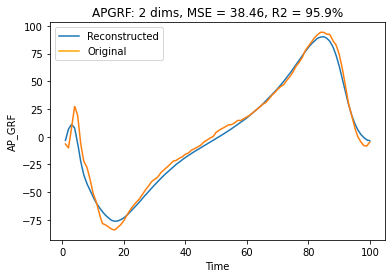

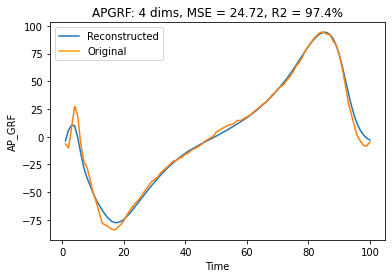

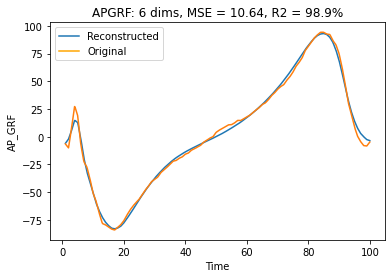

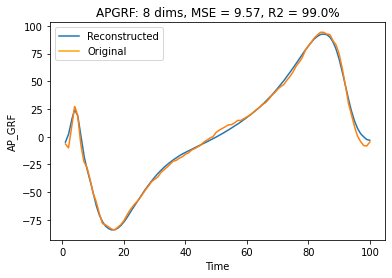

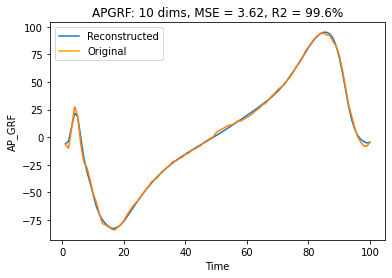

In [47]:
titles = ['APGRF: 2 dims, MSE = 38.46, R2 = 95.9%','APGRF: 4 dims, MSE = 24.72, R2 = 97.4%','APGRF: 6 dims, MSE = 10.64, R2 = 98.9%','APGRF: 8 dims, MSE = 9.57, R2 = 99.0%','APGRF: 10 dims, MSE = 3.62, R2 = 99.6%']

legend_elements = [Line2D([0], [0], label='Reconstructed'), 
                   Line2D([0], [0], color='orange', label='Original')]

for i in range(5):
    fig = comb_fd[i].plot()
    fig.show()
    plt.title(titles[i])
    plt.xlabel("Time")
    plt.ylabel("AP_GRF")
    plt.legend(handles = legend_elements)

# Latent Space Outlier Analysis

In [155]:
with torch.no_grad():
    recondata, latentmu, latentlv = models_npars[2](torch.tensor(AP_GRF_stance_N_matrix, dtype=torch.float32))
    recondata = recondata.numpy()
    latentmu = latentmu.numpy()
    latentlv = latentlv.numpy()

In [156]:
latent_PCA = PCA()
latent_PCA.fit(latentmu[trainidx])
latentmu_PCA = latent_PCA.transform(latentmu)

In [157]:
lof = LocalOutlierFactor()
lof.fit(latentmu_PCA)
outidx = np.argsort(lof.negative_outlier_factor_)

In [158]:
for i in range(10):
    j = outidx[i]
    print('O%i | ID : %i | Trial: %i | Leg: %s | Trial Length: %i' % (i+1, int(ID_info_matrix[j,0]), int(ID_info_matrix[j,2]), ID_info_matrix[j,1] , int(ID_info_matrix[j,3])))

O1 | ID : 136 | Trial: 3 | Leg: LEFT | Trial Length: 778
O2 | ID : 1664 | Trial: 4 | Leg: RIGHT | Trial Length: 772
O3 | ID : 1487 | Trial: 2 | Leg: LEFT | Trial Length: 688
O4 | ID : 1865 | Trial: 2 | Leg: RIGHT | Trial Length: 783
O5 | ID : 1210 | Trial: 5 | Leg: RIGHT | Trial Length: 757
O6 | ID : 78 | Trial: 3 | Leg: RIGHT | Trial Length: 771
O7 | ID : 89 | Trial: 5 | Leg: RIGHT | Trial Length: 708
O8 | ID : 148 | Trial: 3 | Leg: LEFT | Trial Length: 821
O9 | ID : 679 | Trial: 1 | Leg: RIGHT | Trial Length: 976
O10 | ID : 1614 | Trial: 3 | Leg: LEFT | Trial Length: 783


In [130]:
def plot_outliers(subsel, offset=3):
    AP_GRF_stance_N_out = AP_GRF_stance_N_matrix[outidx[subsel]].copy()
#    weigout = spec_weig[outidx[subsel]]

    AP_GRF_stance_N_out /= np.mean(np.abs(AP_GRF_stance_N_out), axis=1)[:,None]
    AP_GRF_stance_N_outfil = AP_GRF_stance_N_out.copy()
#    specoutfil[weigout == 0] = float('nan')

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    for i in range(len(subsel)):
        plt.plot(grid_points_100, AP_GRF_stance_N_out[i] + offset*i, zorder=-i-0.01, c=colors[subsel[i]], alpha=0.5)
        plt.plot(grid_points_100, AP_GRF_stance_N_outfil[i] + offset*i, zorder=-i, c=colors[subsel[i]])
        plt.text(grid_points_100[-1], AP_GRF_stance_N_out[i,-1] + i*offset, 'O%i' % (subsel[i]+1), color=colors[subsel[i]], fontsize='small')
#    plt.xlim((3250,8800))

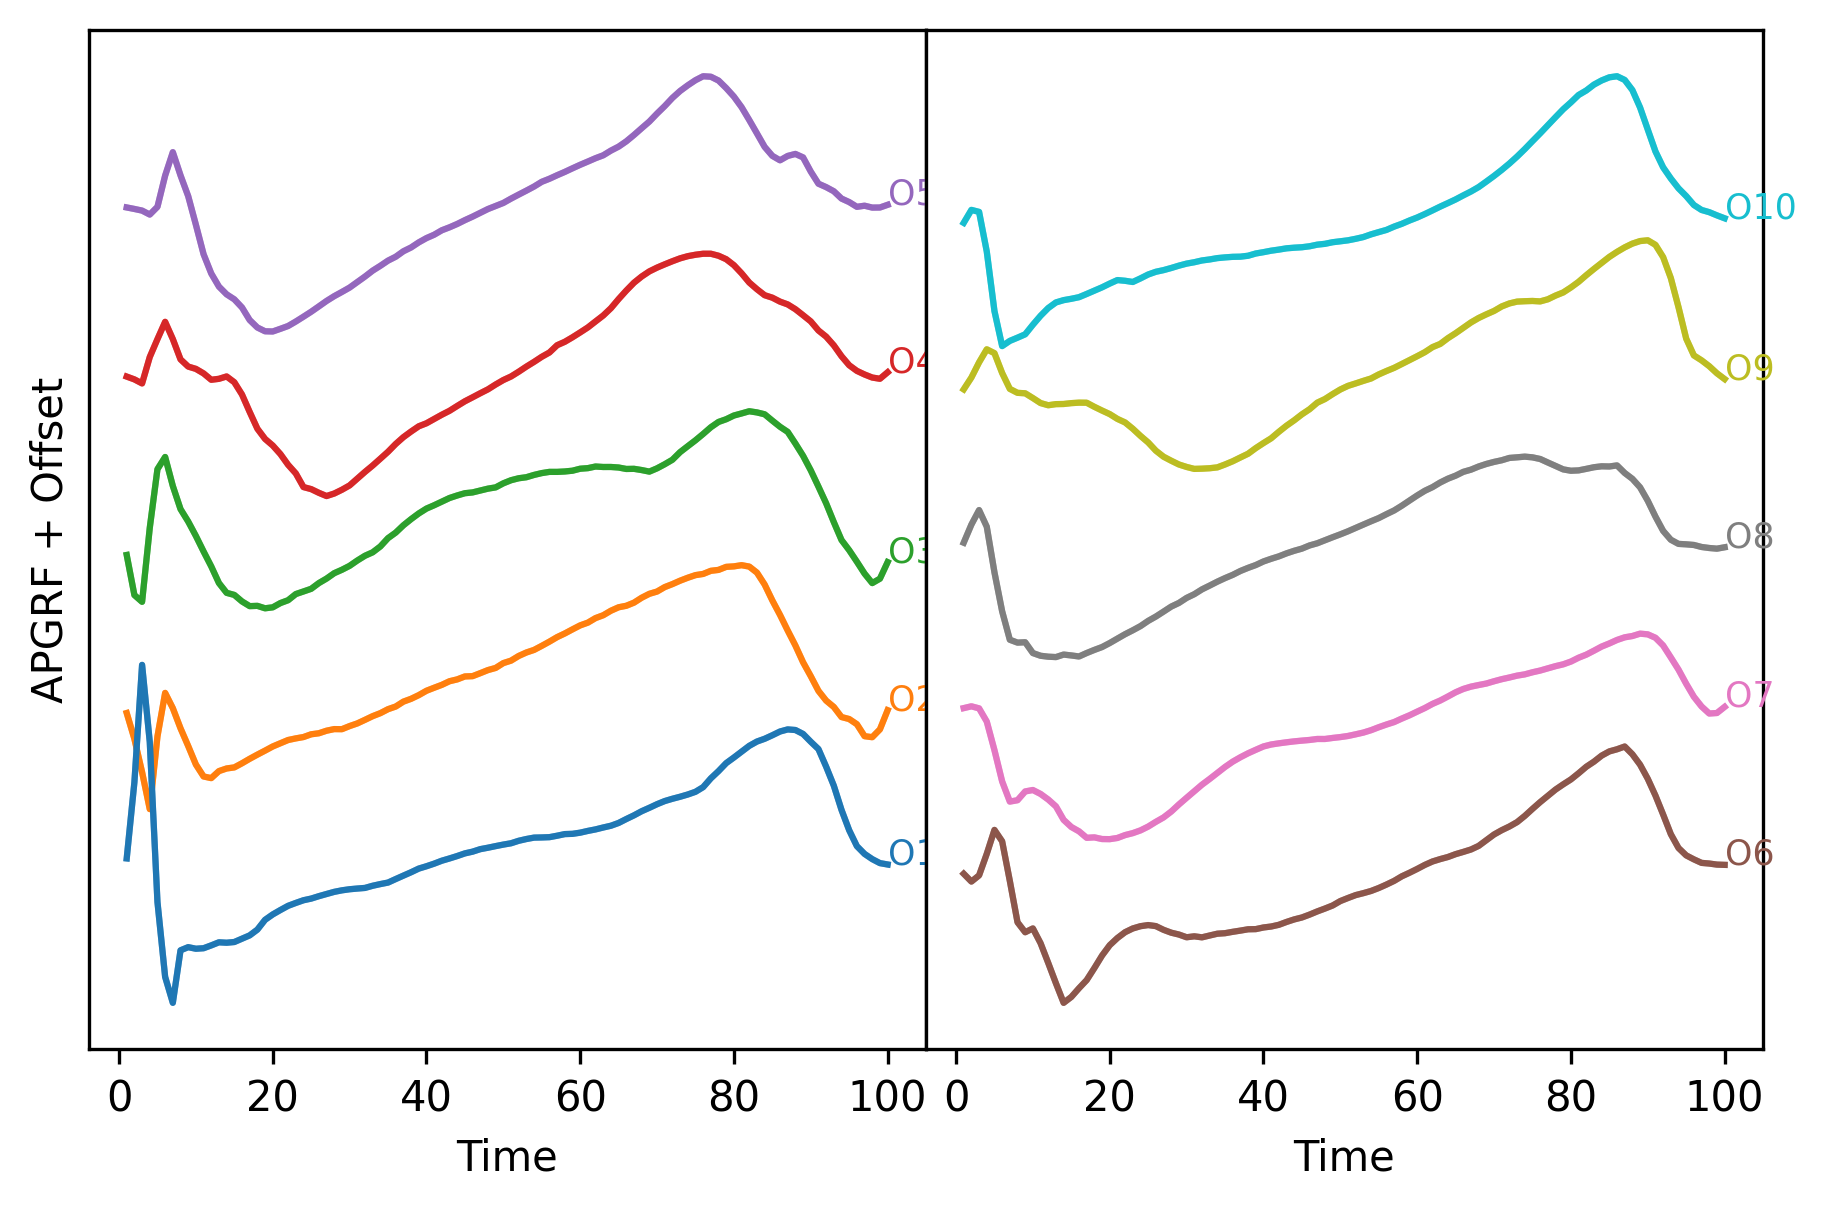

In [131]:
fig = plt.figure(figsize=(7.2,4.5), dpi=300)
fig.subplots_adjust(hspace=0, wspace=0)
plt.subplot(1,2,1)
plt.ylabel('APGRF + Offset')
plt.yticks([])
plt.xlabel('Time')
plot_outliers(range(0,5))
plt.subplot(1,2,2)
plot_outliers(range(5,10))
plt.yticks([])
plt.xlabel('Time')
#plt.savefig('figures/outliers.pdf')
plt.show()